# Imports, loading features and DB

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

import feature_extraction.haar_features.haar_modules as hm
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [30]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

# Classification

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
# hd = MorphologyCalcificationDetection(rbd_img_path='/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/new_rbd',
#                                       threshold=0.96, min_distance=6,
#                                       area=14*14, filter_muscle_region=True, )

## Split data into 2 chunks, otherwise impossible to fit in RAM

In [5]:
first_half_imgs = [20587054, 20587080, 20587148, 20587174, 20587200, 20587226,
                   20587294, 20587320, 20587346, 20587372, 20587466, 20587492,
                   20587518, 20587544, 20587612, 20587638, 20587664, 20587690,
                   20587758, 20587784, 20587810, 20587836, 20588308, 20588334,
                   22580015, 22580038, 22580068, 22580098, 22580654, 22580680,
                   22580706, 22580732, 22613770, 22613796, 22613822, 22613848,
                   22613918, 22613944, 22613970, 22613996, 22614074, 22614097,
                   22614127, 22614150, 22670278, 22670301, 22670324, 22670347,
                   22678953, 22678980, 22679008, 22679036, 24055149, 24055176,
                   24055203, 24055274, 24055328, 24055355, 24055382, 24055573,
                   24055600, 24055627, 24055654, 24055725, 24055752, 24055779,
                   24055806, 24055877, 24055904, 24055931, 24055958, 24065251,
                   24065270, 24065289, 24065308, 24065380, 24065407, 24065434,
                   24065461, 24065530, 24065557, 24065584, 24065611, 24065680,
                   24065707, 24065734, 24065761, 24065833, 24065860, 24065887,
                   24065914, 26933772, 26933801, 26933830, 26933859, 27829134,
                   27829161, 27829188, 27829215, 30011484, 30011507, 30011530,
                   30011553, 30011798, 30011824]

In [7]:
haar_features_data, haar_features_data_fns = pd.read_pickle('feature_sets/hough1_noHaarF_final_2.pkl')

haar_features_data = haar_features_data[~haar_features_data.img_id.isin(first_half_imgs)]
haar_features_data_fns = haar_features_data_fns[~haar_features_data_fns.img_id.isin(first_half_imgs)]

print(haar_features_data.shape)
haar_features_data.head()

(328750, 157)


img_energy img_entropy img_uniformity   img_min img_10th_perc  \
12380  74.436665    7.330146       0.006716  0.510043      0.522956   
12381  82.615472    7.020814       0.008746  0.581779      0.606707   
12382  46.744877    7.018822       0.008746  0.433644      0.445839   
12383  46.744877    7.018822       0.008746  0.433644      0.445839   
12384  58.675631     6.96125       0.009059  0.487446      0.506456   

      img_90th_perc   img_max  img_mean img_median img_inter_quartile_range  \
12380      0.730093  0.779053  0.611187   0.599892                  0.13863   
12381       0.72561  0.809182  0.647626   0.634326                 0.040172   
12382      0.564562  0.606528   0.48622   0.469154                 0.054161   
12383      0.564562  0.606528   0.48622   0.469154                 0.054161   
12384      0.627152   0.68472  0.545238   0.531743                 0.033537   

       ... patch_glcm_dissimilarity_HL1_2 patch_glcm_dissimilarity_HH1_0  \
12380  ...                    4078.028571                      62.485714   
12381  ...                    8402.514286                      79.342857   
12382  ...                    8005.285714                      74.114286   
12383  ...                    8005.285714                      74.114286   
12384  ...                    5348.885714                      52.371429   

      patch_glcm_dissimilarity_HH1_1 patch_glcm_dissimilarity_HH1_2  \
12380                      60.916667                      49.285714   
12381                      70.305556                           70.4   
12382                      49.444444                      71.914286   
12383                      49.444444                      71.914286   
12384                          54.75                      57.228571   

      candidate_coordinates             patch_coordinates    img_id  \
12380        [229, 2308, 9]    ((2301, 2315), (222, 236))  30011850   
12381       [1120, 1838, 9]  ((1831, 1845), (1113, 1127))  30011850   
12382       [1109, 2904, 8]  ((2897, 2911), (1102, 1116))  30011850   
12383       [1109, 2904, 8]  ((2897, 2911), (1102, 1116))  30011850   
12384       [1336, 2109, 7]  ((2102, 2116), (1329, 1343))  30011850   

      repeted_idxs matching_gt label  
12380          0.0         1.0  True  
12381          1.0        11.0  True  
12382          2.0         6.0  True  
12383          2.0         7.0  True  
12384          4.0         9.0  True  

[5 rows x 157 columns]

In [7]:
rest_features_data, rest_features_data_fns = pd.read_pickle('feature_sets/gmorph_noHaarF_final.pkl')

rest_features_data = rest_features_data[~rest_features_data.img_id.isin(first_half_imgs)]
rest_features_data_fns = rest_features_data_fns[~rest_features_data_fns.img_id.isin(first_half_imgs)]

print(rest_features_data.shape)
rest_features_data.head()

(131801, 157)


img_energy img_entropy img_uniformity   img_min img_10th_perc  \
121204  49.650478    6.663589       0.011922  0.464849      0.479914   
121205  49.650478    6.663589       0.011922  0.464849      0.479914   
121206  46.992518    7.049434       0.008486  0.433644      0.445839   
121207  46.992518    7.049434       0.008486  0.433644      0.445839   
121208  45.666409    7.132417       0.007965  0.425036      0.434362   

       img_90th_perc   img_max  img_mean img_median img_inter_quartile_range  \
121204      0.534433  0.628407  0.502481   0.494261                 0.019458   
121205      0.534433  0.628407  0.502481   0.494261                 0.019458   
121206      0.564562  0.606528  0.487543   0.469871                 0.061962   
121207      0.564562  0.606528  0.487543   0.469871                 0.061962   
121208      0.545194  0.615136   0.48052   0.462339                 0.075412   

        ... patch_glcm_dissimilarity_HL1_2 patch_glcm_dissimilarity_HH1_0  \
121204  ...                    7343.285714                           63.0   
121205  ...                    7343.285714                           63.0   
121206  ...                    7021.628571                           64.2   
121207  ...                    7021.628571                           64.2   
121208  ...                    3501.828571                      57.485714   

       patch_glcm_dissimilarity_HH1_1 patch_glcm_dissimilarity_HH1_2  \
121204                      65.444444                      66.828571   
121205                      65.444444                      66.828571   
121206                      59.583333                      64.314286   
121207                      59.583333                      64.314286   
121208                      55.361111                      47.771429   

       candidate_coordinates             patch_coordinates    img_id  \
121204        [662, 3094, 3]    ((3087, 3101), (655, 669))  30011850   
121205        [662, 3094, 3]    ((3087, 3101), (655, 669))  30011850   
121206       [1108, 2905, 4]  ((2898, 2912), (1101, 1115))  30011850   
121207       [1108, 2905, 4]  ((2898, 2912), (1101, 1115))  30011850   
121208       [1176, 2893, 2]  ((2886, 2900), (1169, 1183))  30011850   

       repeted_idxs matching_gt label  
121204          0.0        14.0  True  
121205          0.0        15.0  True  
121206          2.0         6.0  True  
121207          2.0         7.0  True  
121208          4.0         5.0  True  

[5 rows x 157 columns]

In [8]:
haar_features_data = haar_features_data.drop(columns=[x for x in haar_features_data.columns if 'haar' not in x])


In [9]:
all_features_set = pd.concat([haar_features_data, rest_features_data], axis=1)

In [10]:
pd.to_pickle((all_features_set, rest_features_data_fns), 'feature_sets/gmorph_allFeat_final_half2.pkl')

# TO DO:

**I. Cascade Classification**
1. Which features/classifiers are better to use on what stage. We'd like to know wich quick feature set can reduce number of candidates with retaining high sensitivity so we can in the next steps of cascade use more features (more complex ones) for detection?
    1. Feature extraction time by type
    2. False postivie reduction power with a goal for retaining 0.99 sensitivity

2. Build the cascaded classification. Show FP reduction and sensitivity changes of each step of cascade. Make it parametrized.
    1. Check if there is a point in using a cumulative set of features or only the new one.
    2. Check feature importances for each step of cascade.

3. Do hard negative mining. Use pool of negative samples to mine hard ones for every step of cascade training to get more robust classifiers.


**II. All features together Classification**

In [5]:
from xgboost import XGBRFClassifier

In [6]:
# features_data, features_data_fns = pd.read_pickle('feature_sets/gmorph_allFeat_final_half1.pkl')
features_data, features_data_fns = pd.read_pickle('feature_sets/hough1_noHaarF_final_2.pkl')

General avg sensitivity (max froc auc that we can achieve)

In [7]:
# all TP / (all TP + all FN)
features_data.label.sum()/(features_data.label.sum() + len(features_data_fns))

0.9714689265536723

In [8]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                'fos+gabor+wavelet':fos_cols+gabor_cols+wavelet_cols}
                #  'fos+gabor+wavelet+haar':fos_cols+gabor_cols+wavelet_cols+haar_cols}


In [9]:
# need to add SVC but a fast implementation or just wait a lot
classifiers = {'XGBRF': XGBRFClassifier(n_estimators=100, max_depth=6, n_jobs=6),
            #    'RF': RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=6),
               'SVC':SVC(C=10, probability=True)}


### Casade Analysis

In [10]:
# adding case_id column
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

In [9]:
# features_data['raw_mask_intersection'] = 0
# for img_id in tqdm(db.df.img_id.unique()):
#     raw_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
#     for idx, row in features_data[features_data.img_id == img_id].iterrows():
#         (ppx1, ppx2), (ppy1, ppy2)= row['patch_coordinates']
#         features_data.at[idx, 'raw_mask_intersection'] = (raw_mask[ppx1:ppx2, ppy1:ppy2]>0).sum()

100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


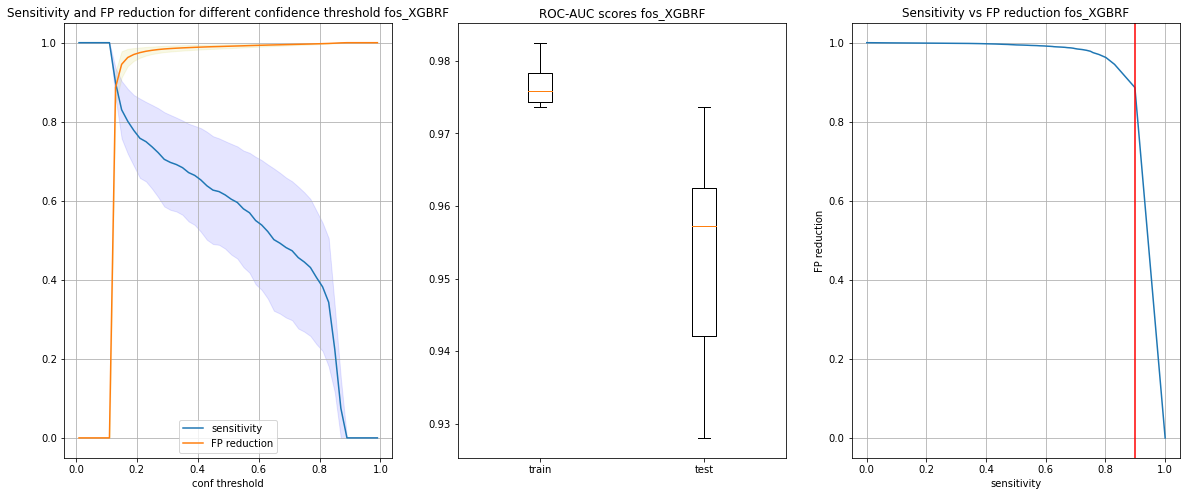

100%|██████████| 5/5 [28:52<00:00, 346.46s/it]


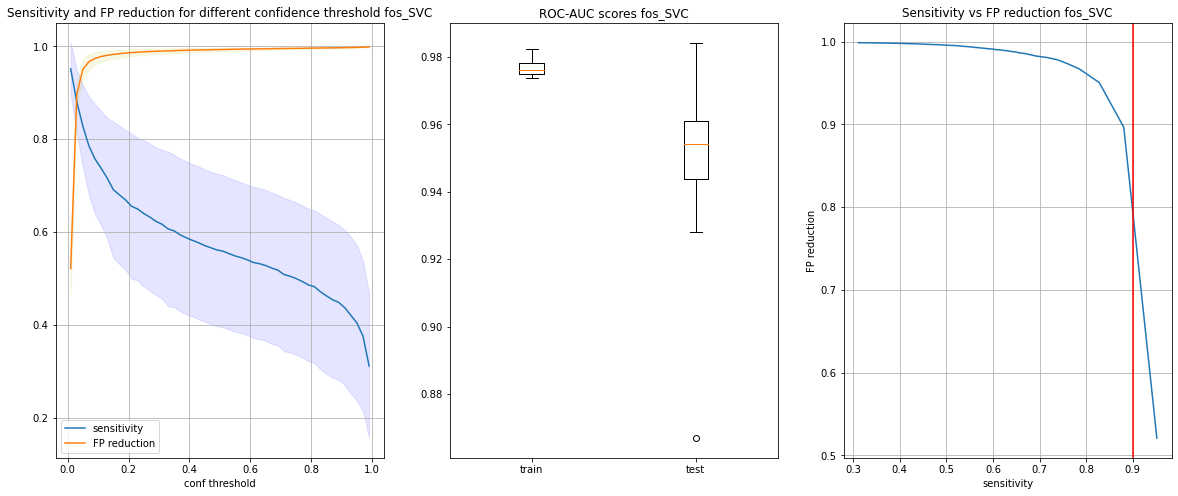

100%|██████████| 5/5 [01:24<00:00, 16.82s/it]


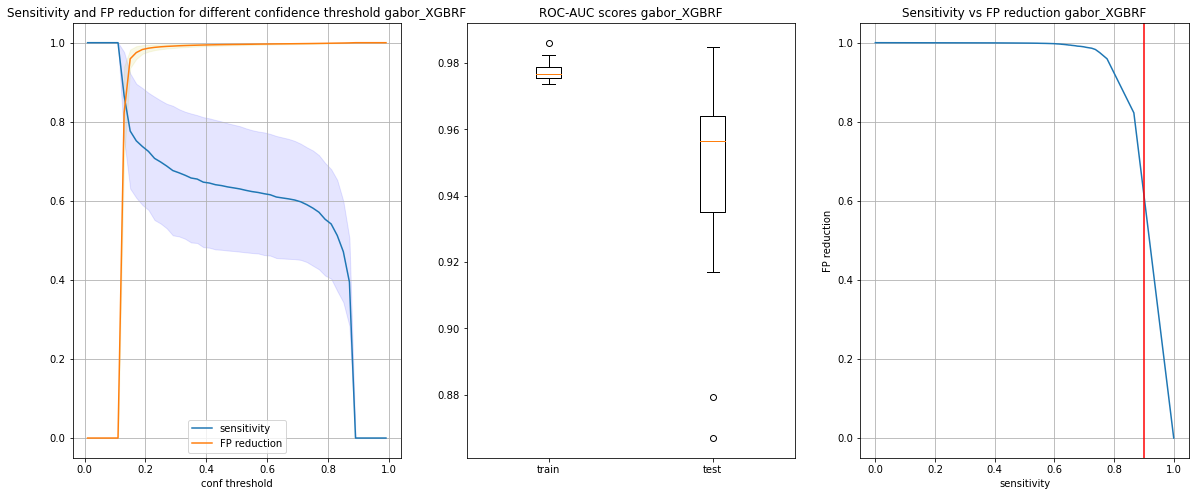

 20%|██        | 1/5 [01:20<05:23, 80.79s/it]


KeyboardInterrupt: 

In [14]:
kfolds = 5
FP2TP_rate = 10
desired_sensitivity = 0.9

conf_thresholds = np.linspace(0.01, 0.99)

# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

roc_aucs = []


# classifiers = {'RF': RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)}

results = {}

for feature_set_name, features_set in features_sets.items():

    for clf_name, clf in classifiers.items():
        
        fpr_sens_curve = []

        # kfold CV
        for valid_case_ids in tqdm(kfolds_case_splits):

            # split data into test
            test_split_mask = features_data.case_id.isin(valid_case_ids)
            
            # split into train and take into account cleaned data with no mC in the borders of the patch
            cleaned_features_data = features_data[~test_split_mask]
            
            # and sampling to a predefined 1:FP2TP_rate TP:FP samples
            positive_mask = (cleaned_features_data.label>0)
            positive_train_part = cleaned_features_data[positive_mask]
            negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING
            
            train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
            
            
            
            test_df = features_data[test_split_mask]
            
            train_y = train_df.label#.astype(int)
            test_y = test_df.label#.astype(bool)
            
            scaler = MinMaxScaler()
            train_X_scaled = scaler.fit_transform(train_df[features_set].values)
            test_X_scaled = scaler.transform(test_df[features_set].values)
            
            clf.fit(train_X_scaled, train_y)

            train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
            test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
            
            roc_aucs.append((roc_auc_score(train_y, train_y_predicted),
                            roc_auc_score(test_y, test_y_predicted)))
            
            sens_fpr = []
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
                TP = (test_y & test_y_pred_binarized).sum()
                FN = (test_y & ~test_y_pred_binarized).sum()
                FP = (~test_y & test_y_pred_binarized).sum()
                max_FP_possible = (~test_y).sum()
                sens = TP/(TP + FN)
                sens_fpr.append((sens, 1 - FP/max_FP_possible))
                
            fpr_sens_curve.append(sens_fpr)

        # mean and std batch-wise of fpr and sensitivity
        fpr_sens_curve_mean = np.asarray(fpr_sens_curve).mean(axis=0)
        fpr_sens_curve_std = np.asarray(fpr_sens_curve).std(axis=0)


        fig, axs = plt.subplots(1, 3, figsize=(20, 8))

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,0])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,0]-fpr_sens_curve_std[:,0]), (fpr_sens_curve_mean[:,0]+fpr_sens_curve_std[:,0]), color='b', alpha=.1)

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,1])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,1]-fpr_sens_curve_std[:,1]), (fpr_sens_curve_mean[:,1]+fpr_sens_curve_std[:,1]), color='y', alpha=.1)

        axs[0].legend(['sensitivity', 'FP reduction'])
        axs[0].grid()
        axs[0].set_xlabel('conf threshold')
        axs[0].set_title(f'Sensitivity and FP reduction for different confidence threshold {feature_set_name}_{str(clf_name)}')

        axs[1].set_title(f'ROC-AUC scores {feature_set_name}_{str(clf_name)}')
        axs[1].boxplot(np.array(roc_aucs), labels=['train', 'test'])

        axs[2].plot(fpr_sens_curve_mean[:,0], fpr_sens_curve_mean[:,1])
        axs[2].set_xlabel('sensitivity')
        axs[2].set_ylabel('FP reduction')
        axs[2].set_title(f'Sensitivity vs FP reduction {feature_set_name}_{str(clf_name)}')
        axs[2].axvline(desired_sensitivity, c='r')
        axs[2].grid()

        plt.show()
        
        results[f'{feature_set_name}_{str(clf_name)}'] = fpr_sens_curve_mean


FP reduction show how many of the FP candidates were classified as negatives (aka reduction of FP)

### Final comparison graph

In [11]:
plt.figure(figsize=(10,10))

for fs, fs_res in results.items():
    plt.plot(fs_res[:,0], fs_res[:,1])

plt.axvline(desired_sensitivity, c='r')
plt.legend(results.keys())
plt.xlabel('sensitivity')
plt.ylabel('FP reduction')


NameError: name 'results' is not defined

<Figure size 720x720 with 0 Axes>

## FROC Curve and final Metrics

In [12]:
FP2TP_rate = 10
features_set = features_sets['fos+gabor+wavelet']

In [13]:
validation_img_ids = db.df[db.df.partition == 'validation'].img_id.values



# split data into test
test_split_mask = features_data.img_id.isin(validation_img_ids)

train_fns_df = features_data_fns[~features_data_fns.img_id.isin(validation_img_ids)]
# test_df = data[data.img_id.isin(test_img_id)]
test_fns_df = features_data_fns[features_data_fns.img_id.isin(validation_img_ids)]


# split into train and take into account cleaned data with no mC in the borders of the patch
cleaned_features_data = features_data[~test_split_mask]

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = cleaned_features_data.label
positive_train_part = cleaned_features_data[positive_mask]
negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum())

print(f'FP:TP rate: {len(negative_train_part)/len(positive_train_part)}:1')

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

test_df = features_data[test_split_mask]

FP:TP rate: 10.0:1


In [14]:
len(test_df)/len(features_data)


0.33467299856359745

In [17]:
final_clf = classifiers['SVC']# XGBRFClassifier(n_estimators=100, max_depth=8, n_jobs=-1)#

train_y = train_df.label
test_y = test_df.label

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_df[features_set].values)
test_X_scaled = scaler.transform(test_df[features_set].values)

final_clf.fit(train_X_scaled, train_y)

test_y_predicted = final_clf.predict_proba(test_X_scaled)[:, 1]
train_y_predicted = final_clf.predict_proba(train_X_scaled)[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')


Auc test: 0.7583221733658848


In [18]:
test_df['confidence'] = test_y_predicted
train_df['confidence'] = train_y_predicted

train_df['labels'] = train_df['label'] 
test_df['labels'] = test_df['label'] 

/tmp/ipykernel_5374/427785115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence'] = test_y_predicted
/tmp/ipykernel_5374/427785115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df['label']


In [22]:
froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    train_fns_df,
    train_y_predicted
)


sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train')




froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    test_fns_df,
    test_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='test')

# avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
# plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)

In [23]:
bad_forcs = froc_df.sort_values(by=['pred_scores'], ascending=False)#.head(40)
bad_forcs = bad_forcs[bad_forcs.detection_labels =='FP']
bad_forcs#[bad_forcs.img_id == 20587664].head(40)

x     y  radius detection_labels   pred_scores    img_id  \
76094   353  2589     9.0               FP  1.000000e+00  50996709   
76595   317  2586     9.0               FP  1.000000e+00  50996709   
76597   369  2600     9.0               FP  1.000000e+00  50996709   
76323   365  2610     9.0               FP  1.000000e+00  50996709   
76821   344  2583     8.0               FP  1.000000e+00  50996709   
...     ...   ...     ...              ...           ...       ...   
12090   975  1262     8.0               FP  1.189176e-07  30011824   
45825   767  1342     6.0               FP  1.036004e-07  50994814   
9915   1069  1517     9.0               FP  1.000000e-07  30011824   
10327  1316  1627     8.0               FP  1.000000e-07  30011824   
45447   737  1949     9.0               FP  1.000000e-07  50994814   

      matching_gt repeted_idxs  pred_binary  class_labels  
76094         NaN         64.0        False         False  
76595         NaN        565.0        False         False  
76597         NaN        567.0        False         False  
76323         NaN        293.0        False         False  
76821         NaN        791.0        False         False  
...           ...          ...          ...           ...  
12090         NaN       3032.0        False         False  
45825         NaN       1670.0        False         False  
9915          NaN        857.0        False         False  
10327         NaN       1269.0        False         False  
45447         NaN       1292.0        False         False  

[113398 rows x 10 columns]

### Problems
1. ~~Duplicates in candidates, why?~~
2. Loss of labels in masks (including origianl masks) -> 22670177_lesion_mask.png
3. ~~Not properly saved labels in INBreast db from original mask (present in original not in one from the class) -> 20587174~~
4. ~~Mask labels are not exactly in the center of the patch (even though the mC is in the center, labeled roi is shifted) ->20587466~~
5. Pectoral muscle segmentation??? Some weird lines detection -> 22670147

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


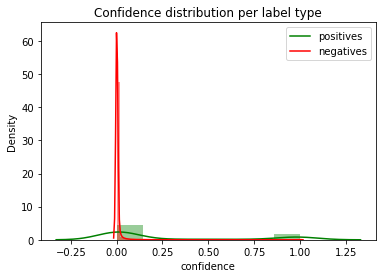

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


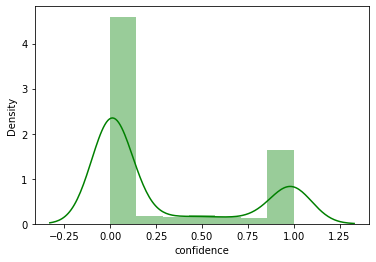

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


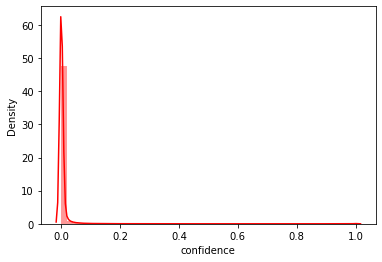

In [24]:
sns.distplot(test_df[test_df.labels].confidence, color='g')
sns.distplot(test_df[~test_df.labels].confidence, color='r')
plt.legend(['positives', 'negatives'])
plt.title('Confidence distribution per label type')
plt.show()

sns.distplot(test_df[test_df.labels].confidence, color='g')
plt.show()

sns.distplot(test_df[~test_df.labels].confidence, color='r')
plt.show()


In [37]:
test_df.head()

img_energy img_entropy img_uniformity   img_min img_10th_perc img_90th_perc  \
0  64.411302    7.091092        0.00833  0.505556      0.524837      0.641176   
1   73.20164     7.06349       0.008486  0.543791      0.557843      0.721242   
2  41.845196    6.851837         0.0101  0.408497      0.421895      0.499183   
3  59.124723    6.724186       0.010881  0.514052      0.530882      0.568301   
4  65.406508    7.307237       0.006768  0.492484      0.511928      0.681373   

    img_max  img_mean img_median img_inter_quartile_range  ...  \
0  0.666013  0.571627   0.553922                 0.066993  ...   
1  0.773203   0.60781   0.576797                 0.069281  ...   
2  0.619608  0.460266   0.456046                 0.031699  ...   
3  0.611438   0.54899   0.548366                 0.021324  ...   
4  0.710131  0.574576   0.551961                 0.070261  ...   

  patch_glcm_dissimilarity_HL1_2 patch_glcm_dissimilarity_HH1_0  \
0                    7651.085714                      58.228571   
1                    6179.514286                      60.514286   
2                    6183.542857                      53.942857   
3                    7801.514286                           66.2   
4                         7430.2                      75.285714   

  patch_glcm_dissimilarity_HH1_1 patch_glcm_dissimilarity_HH1_2  \
0                      68.722222                      64.685714   
1                      58.111111                      63.057143   
2                      55.055556                           59.2   
3                      58.361111                      68.028571   
4                      65.833333                      66.314286   

  candidate_coordinates           patch_coordinates    img_id repeted_idxs  \
0        [198, 1661, 9]  ((1654, 1668), (191, 205))  30011507          0.0   
1        [146, 1570, 9]  ((1563, 1577), (139, 153))  30011507          1.0   
2        [693, 1300, 8]  ((1293, 1307), (686, 700))  30011507          2.0   
3        [227, 1483, 6]  ((1476, 1490), (220, 234))  30011507          3.0   
4        [181, 1665, 9]  ((1658, 1672), (174, 188))  30011507          4.0   

  matching_gt label  
0         2.0  True  
1        18.0  True  
2        10.0  True  
3         5.0  True  
4         3.0  True  

[5 rows x 157 columns]

In [48]:
test_df.loc[79298, :]#['candidate_coordinates']

img_energy                            73.551283
img_entropy                            6.530309
img_uniformity                         0.012703
img_min                                0.556664
img_10th_perc                           0.59444
                                ...            
patch_coordinates    ((1175, 1189), (444, 458))
img_id                                 50994895
repeted_idxs                              109.0
matching_gt                                 4.0
label                                      True
Name: 79298, Length: 157, dtype: object

(1175, 1189) (444, 458)


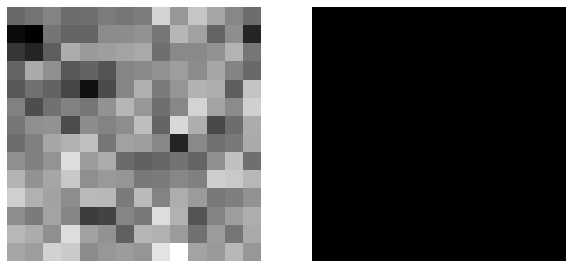

In [49]:
(y1, y2), (x1, x2) = test_df.loc[79298]['patch_coordinates']
print((y1, y2), (x1, x2))
bad_img_id = db.df[db.df.img_id == 50994895].index[0]
image = db[bad_img_id]['img']
mask = db[bad_img_id]['lesion_mask']

simple_im_show2(image[y1:y2, x1:x2], mask[y1:y2, x1:x2])


In [47]:
bad_img_id

130

In [40]:
tp, fp, fn = get_tp_fp_fn_center_patch_criteria(np.array([[451, 1182, 5]]), mask, None, 14)

In [43]:
fn

x     y  radius label matching_gt  repeted_idxs
0  372  1544     0.0    FN        None         False
1  365   846     0.0    FN        None         False
2  358   777     0.0    FN        None         False
3  319   768     0.0    FN        None         False
4  145  1186     0.0    FN        None         False
5  137  1178     0.0    FN        None         False
6  123  1151     0.0    FN        None         False
7  126  1150     0.0    FN        None         False
8   50  1441     0.0    FN        None         False

In [27]:
bads_df = test_df[~test_df.labels].sort_values(by=['confidence'], ascending=False).drop(columns=features_sets['fos+gabor+wavelet'])
bads_df

candidate_coordinates             patch_coordinates    img_id  \
116986        [344, 2583, 8]    ((2576, 2590), (337, 351))  50996709   
70561         [574, 1358, 6]    ((1351, 1365), (567, 581))  50994760   
116760        [317, 2586, 9]    ((2579, 2593), (310, 324))  50996709   
116946        [751, 2587, 9]    ((2580, 2594), (744, 758))  50996709   
116259        [353, 2589, 9]    ((2582, 2596), (346, 360))  50996709   
...                      ...                           ...       ...   
12090         [975, 1262, 8]    ((1255, 1269), (968, 982))  30011824   
74820         [767, 1342, 6]    ((1335, 1349), (760, 774))  50994814   
9915         [1069, 1517, 9]  ((1510, 1524), (1062, 1076))  30011824   
10327        [1316, 1627, 8]  ((1620, 1634), (1309, 1323))  30011824   
74442         [737, 1949, 9]    ((1942, 1956), (730, 744))  50994814   

        repeted_idxs  matching_gt  label           case_id    confidence  \
116986         791.0          NaN  False  330e5fe16929eed4  1.000000e+00   
70561         1694.0          NaN  False  069212ec65a94339  1.000000e+00   
116760         565.0          NaN  False  330e5fe16929eed4  1.000000e+00   
116946         751.0          NaN  False  330e5fe16929eed4  1.000000e+00   
116259          64.0          NaN  False  330e5fe16929eed4  1.000000e+00   
...              ...          ...    ...               ...           ...   
12090         3032.0          NaN  False  4f20c1285d8f0b1f  1.189176e-07   
74820         1670.0          NaN  False  069212ec65a94339  1.036004e-07   
9915           857.0          NaN  False  4f20c1285d8f0b1f  1.000000e-07   
10327         1269.0          NaN  False  4f20c1285d8f0b1f  1.000000e-07   
74442         1292.0          NaN  False  069212ec65a94339  1.000000e-07   

        labels  
116986   False  
70561    False  
116760   False  
116946   False  
116259   False  
...        ...  
12090    False  
74820    False  
9915     False  
10327    False  
74442    False  

[113398 rows x 9 columns]

In [28]:
bad_res_FN = test_df[test_df.labels].sort_values(by=['confidence'], ascending=True).drop(columns=features_sets['fos+gabor+wavelet'])

 20%|██        | 20/100 [00:41<02:41,  2.02s/it]/tmp/ipykernel_5374/4072607370.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(4,3, figsize=(20, 8))
 34%|███▍      | 34/100 [01:09<02:11,  1.99s/it]/tmp/ipykernel_5374/4072607370.py:13: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_5374/4072607370.py:17: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(255*(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0), cmap='gray', vmin=0)
/tmp/ipykernel_5374/407

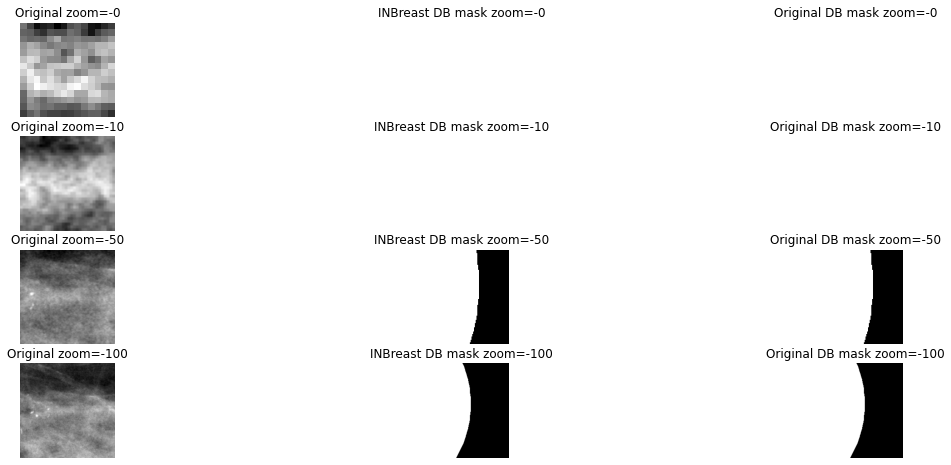

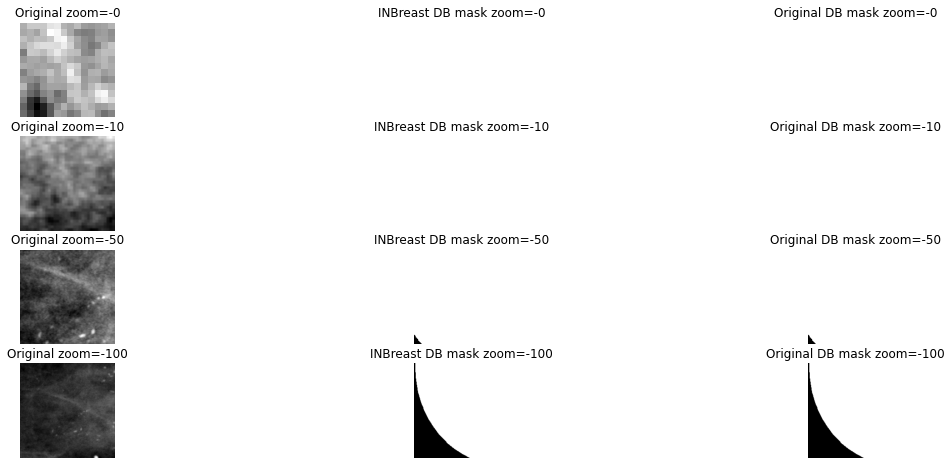

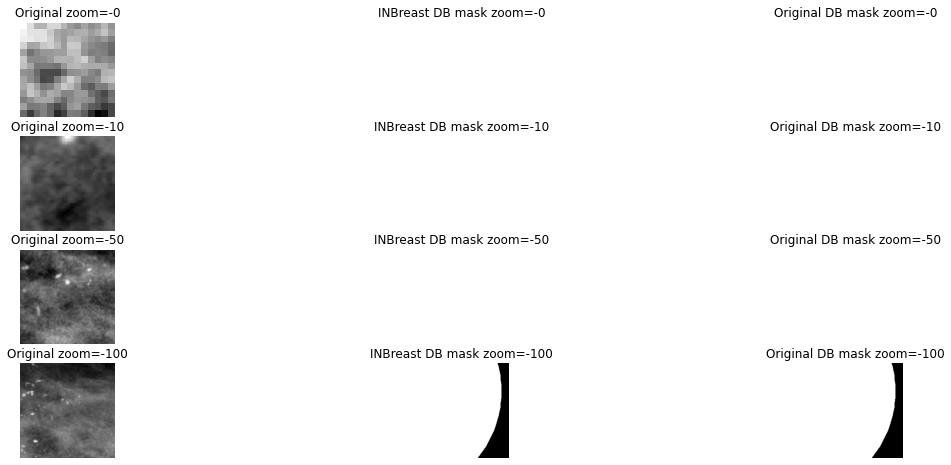

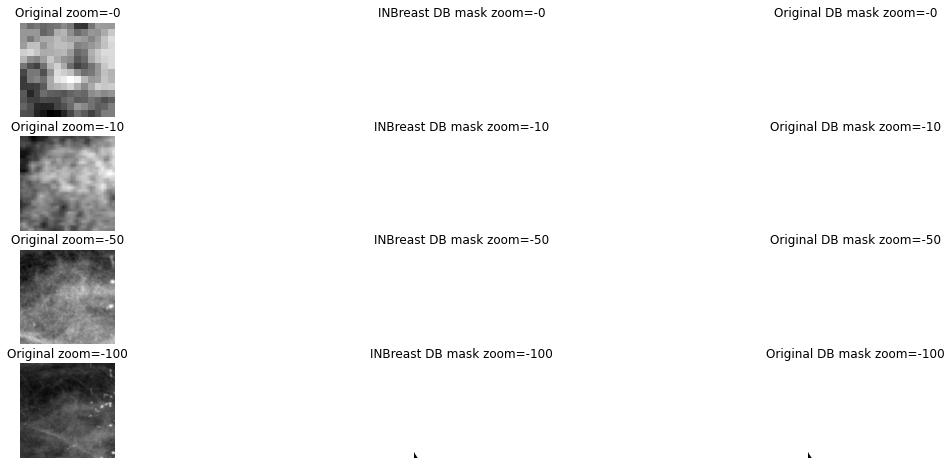

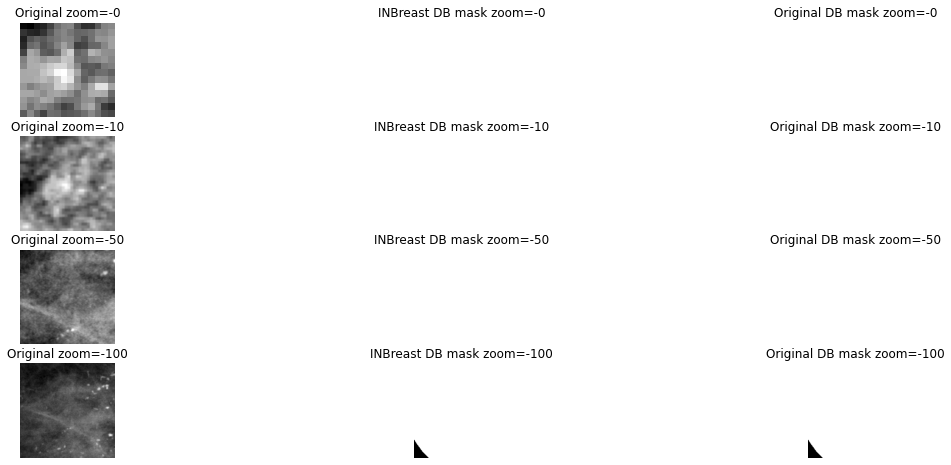

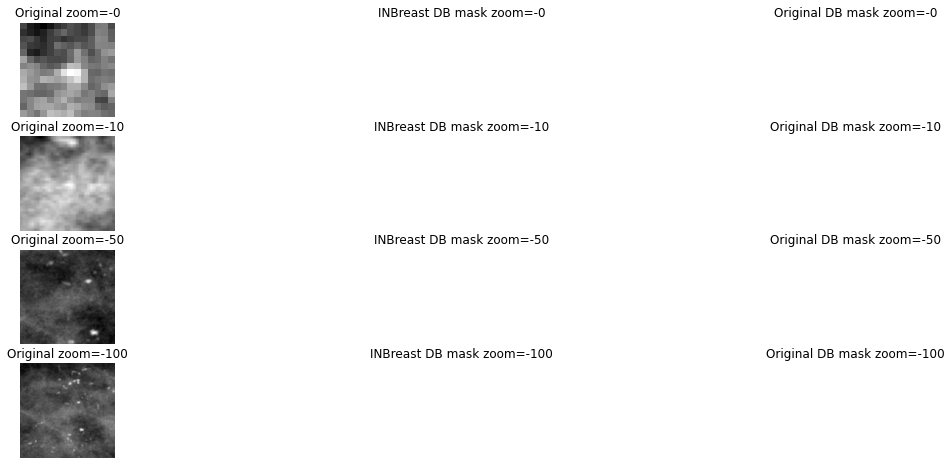

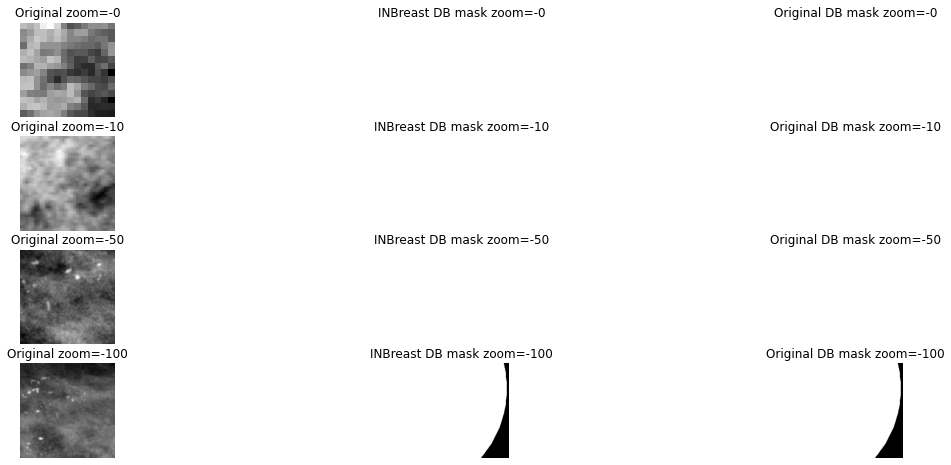

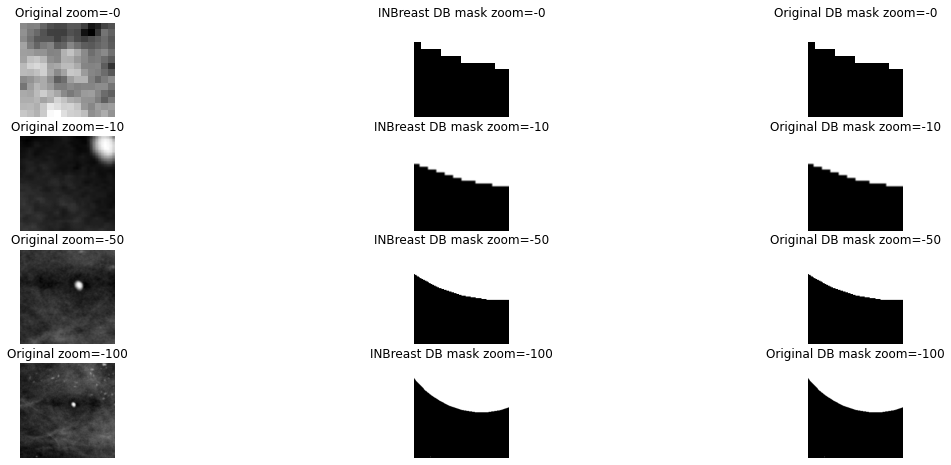

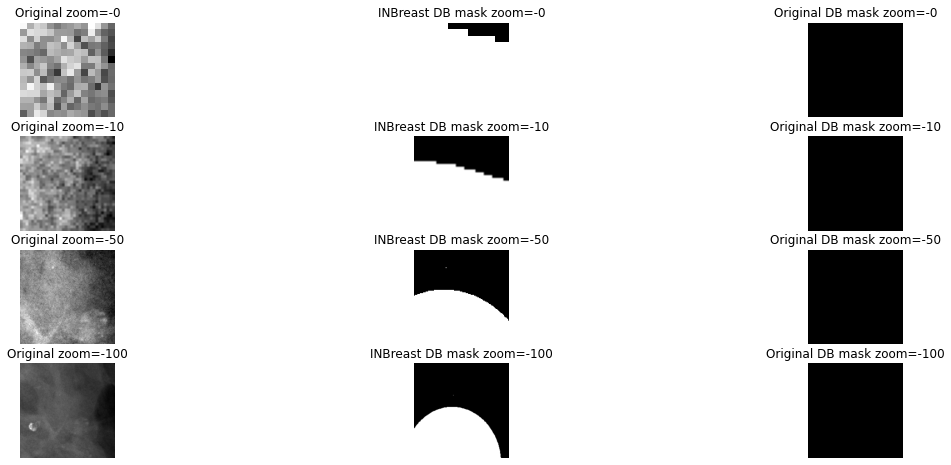

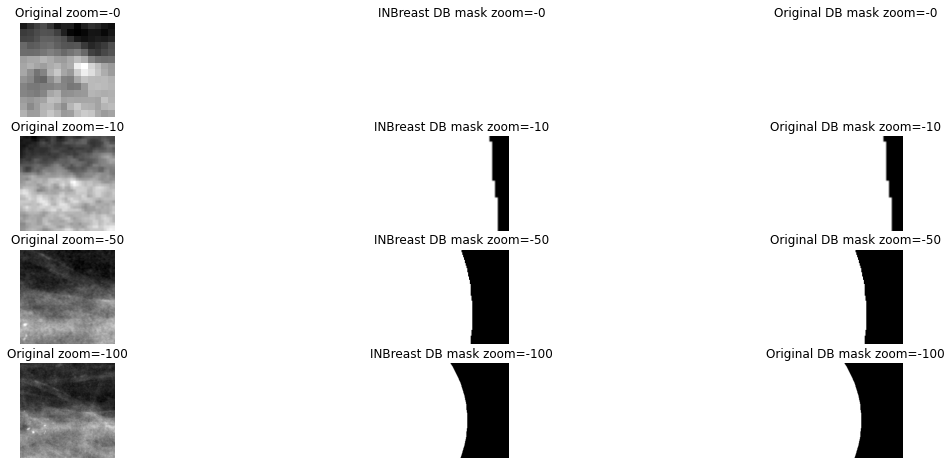

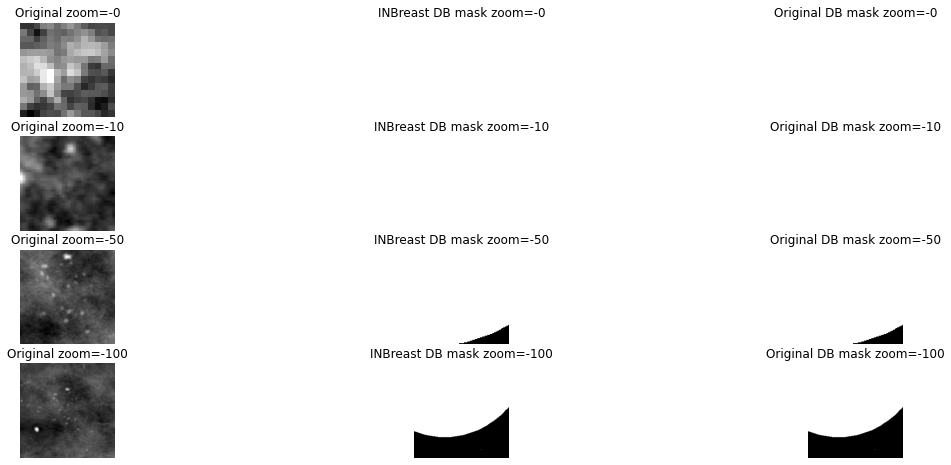

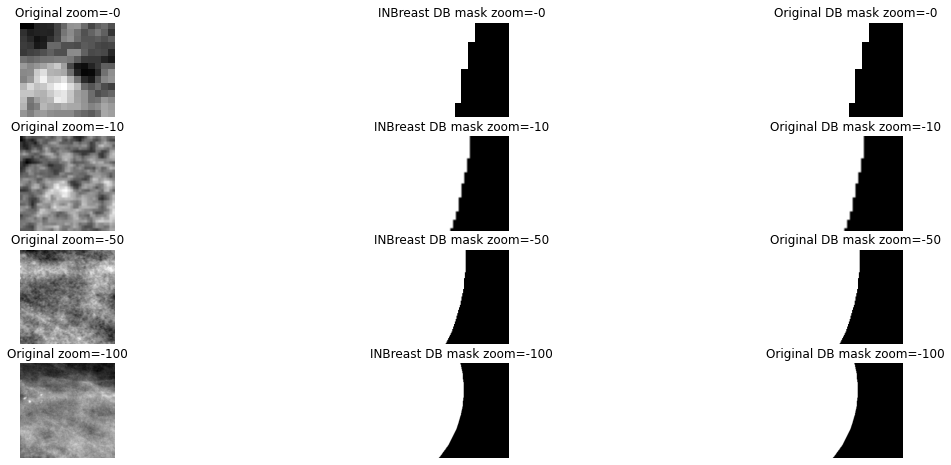

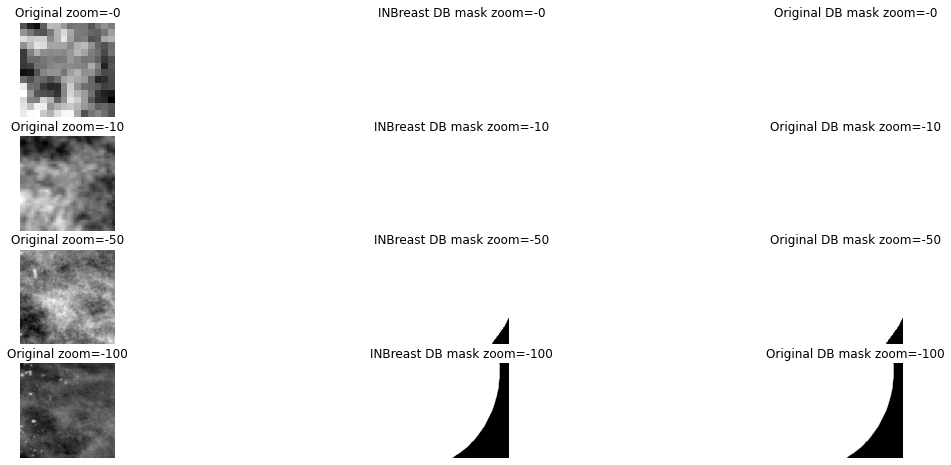

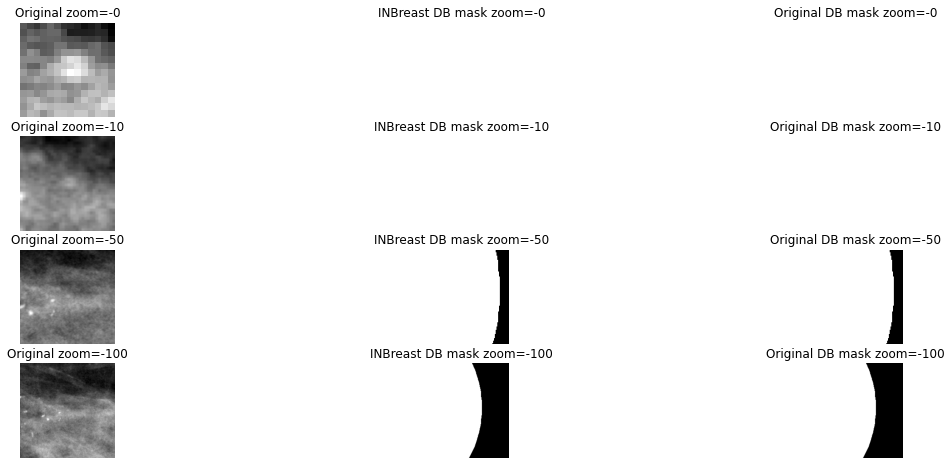

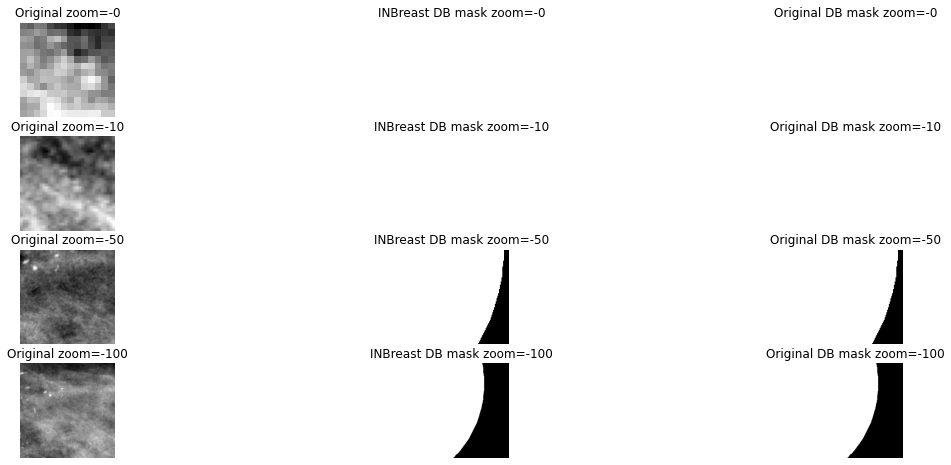

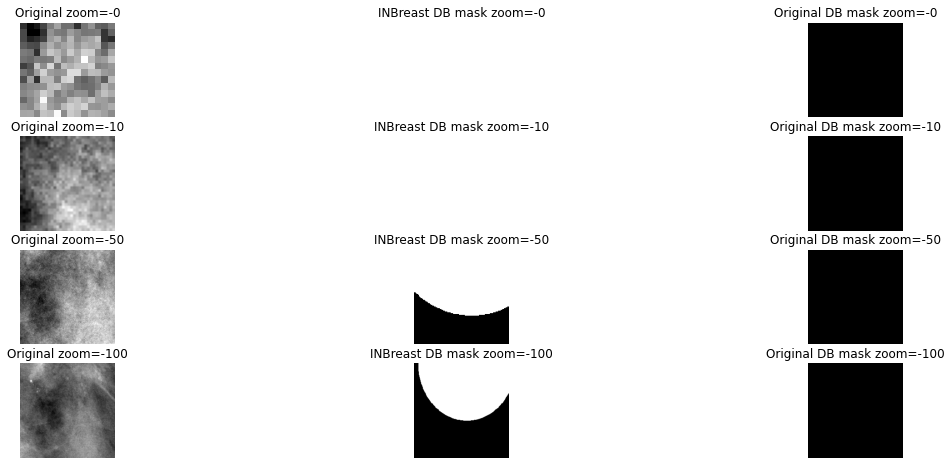

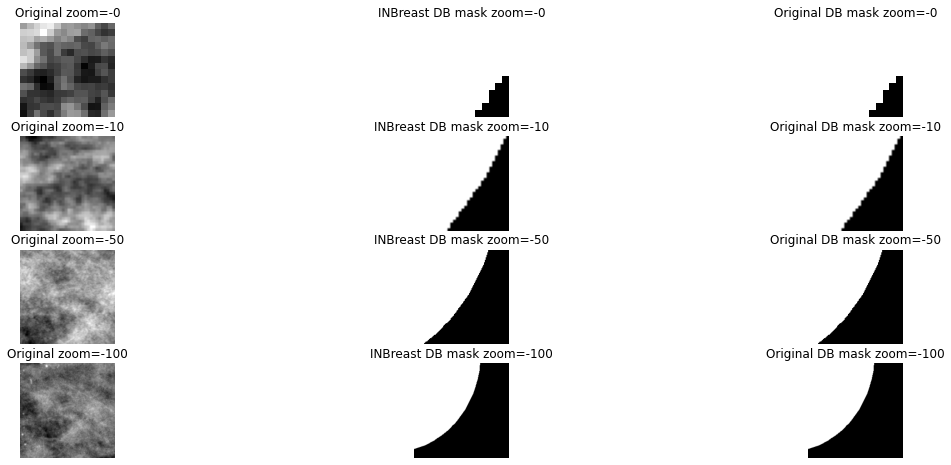

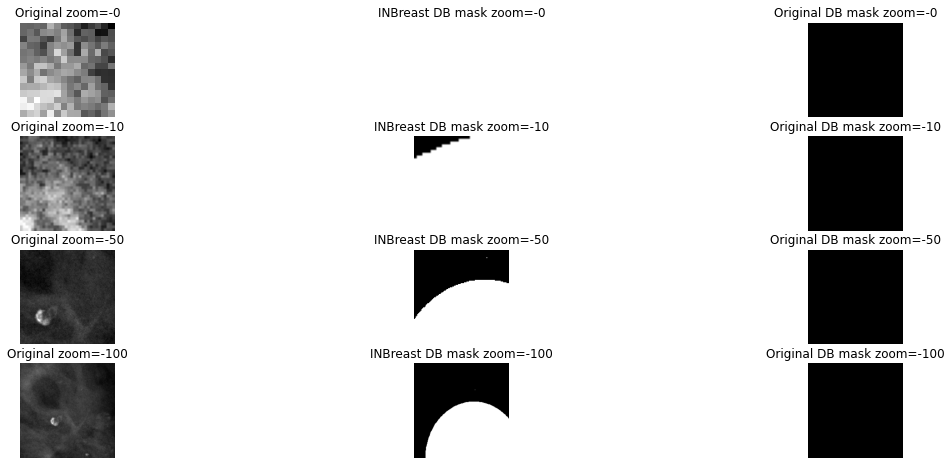

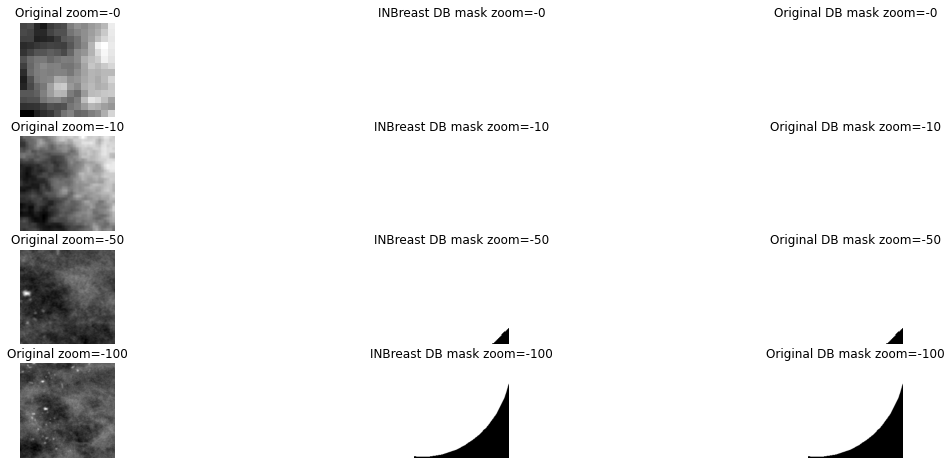

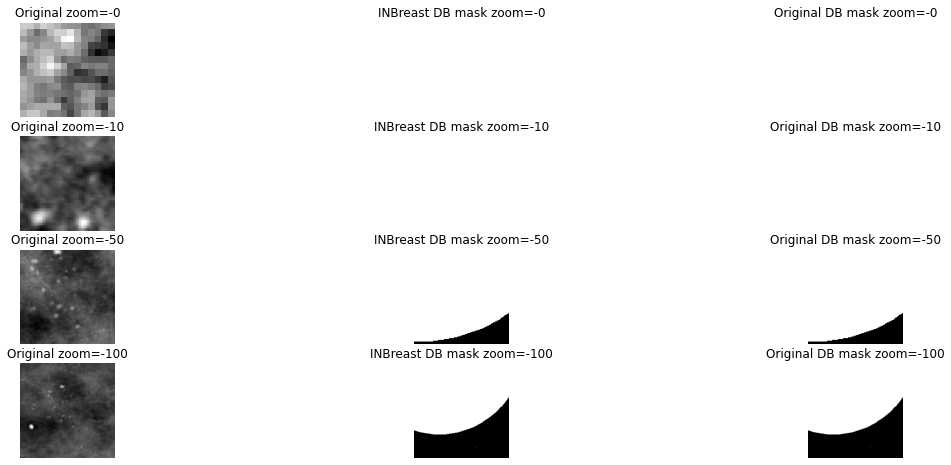

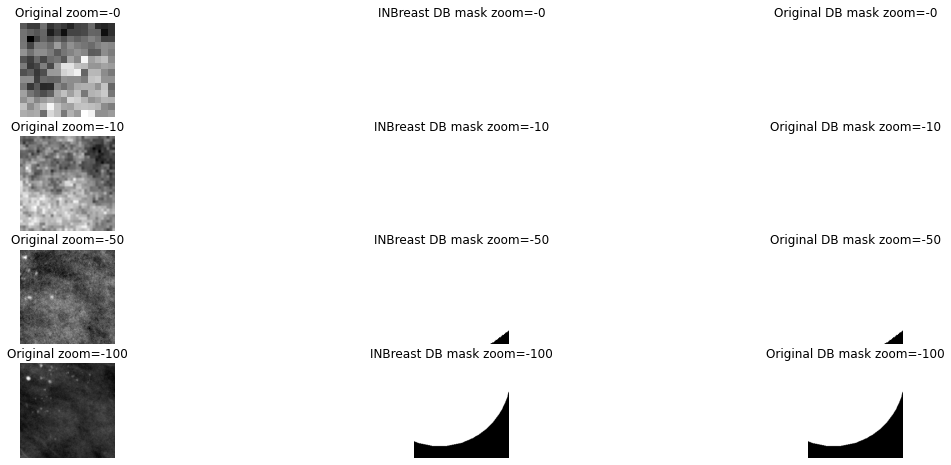

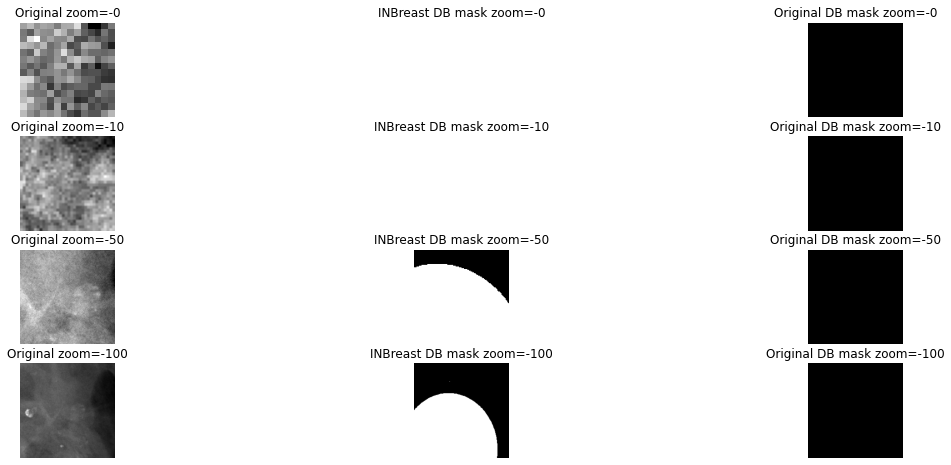

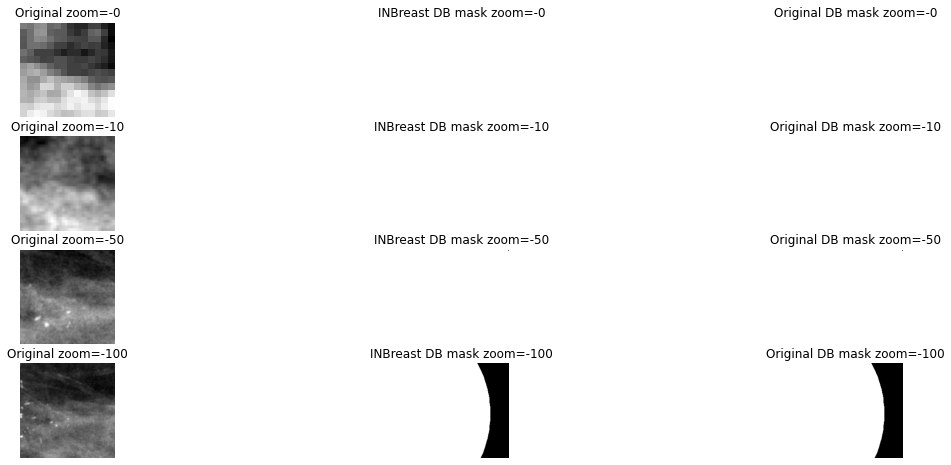

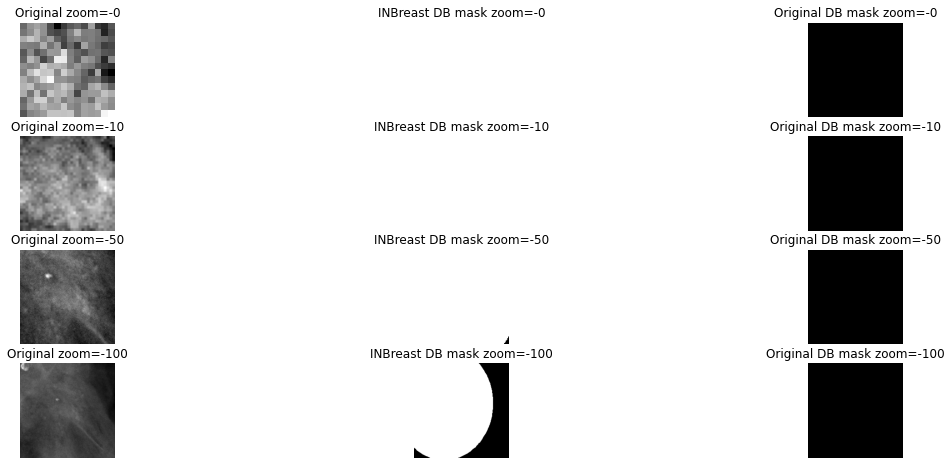

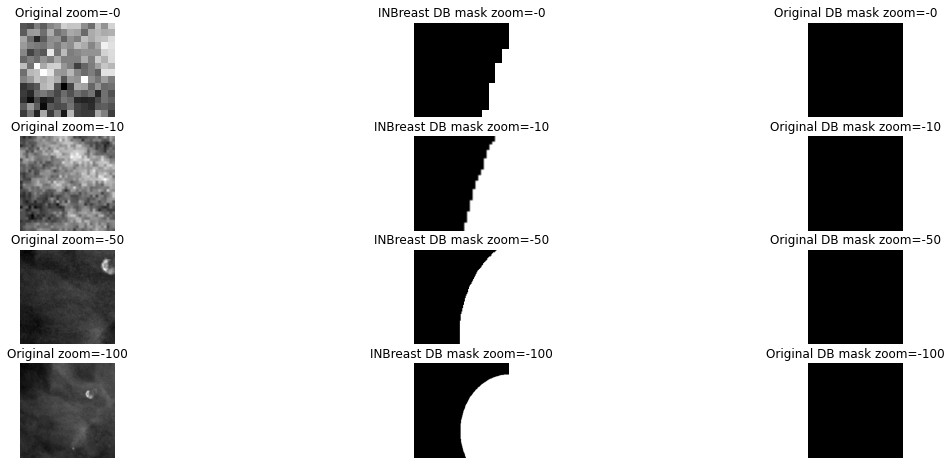

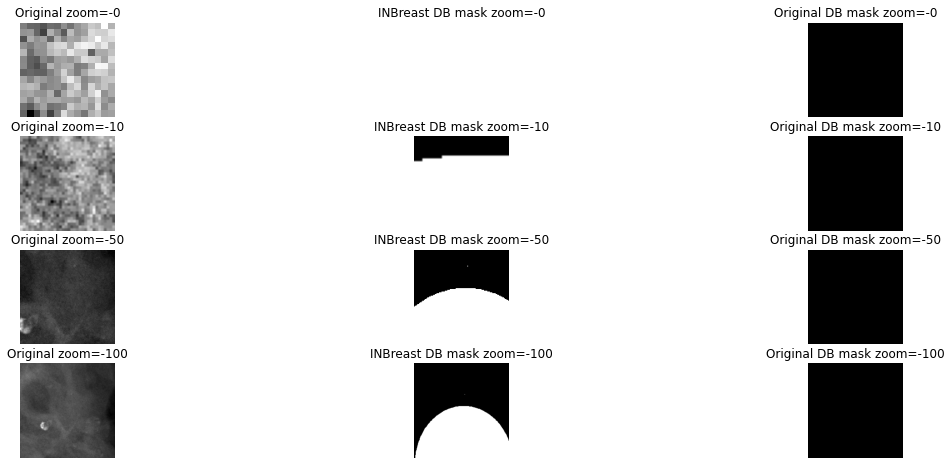

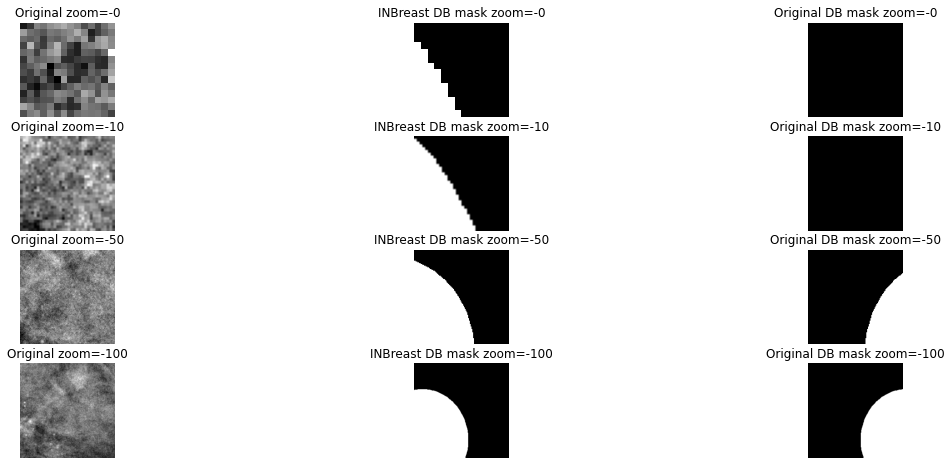

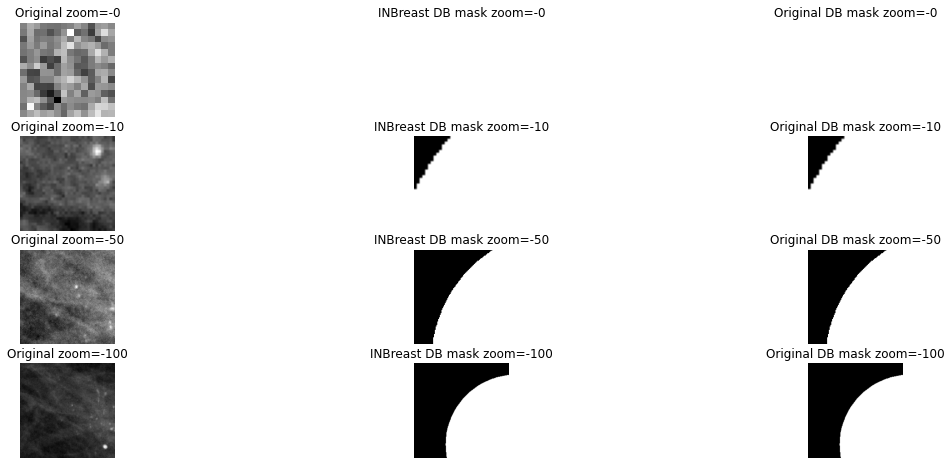

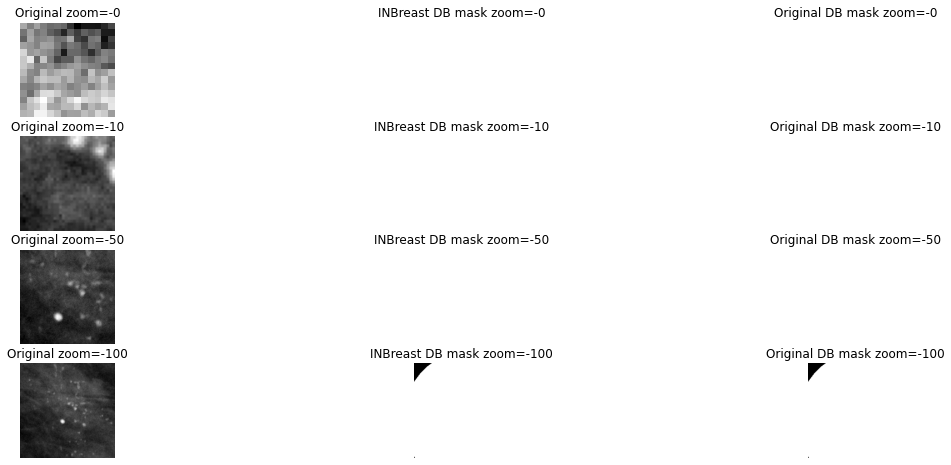

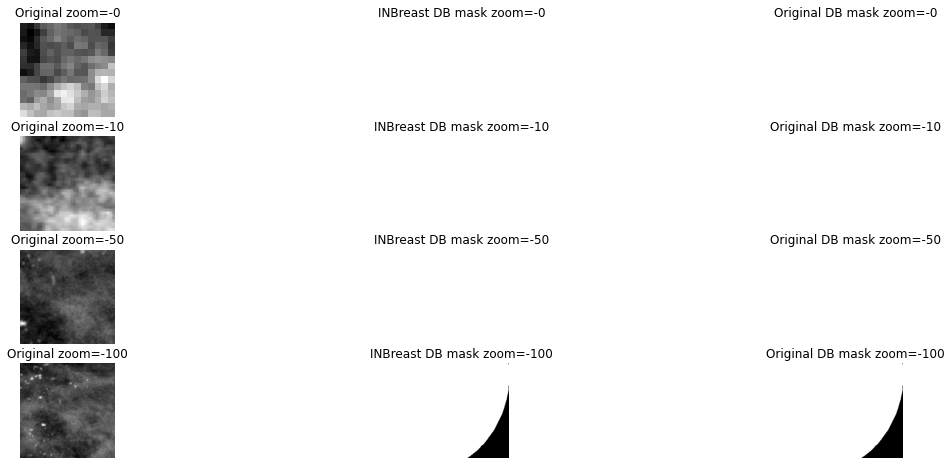

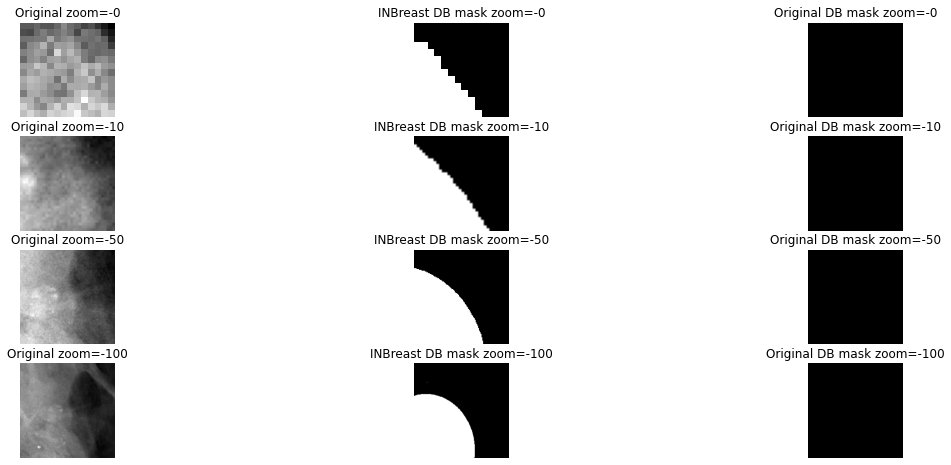

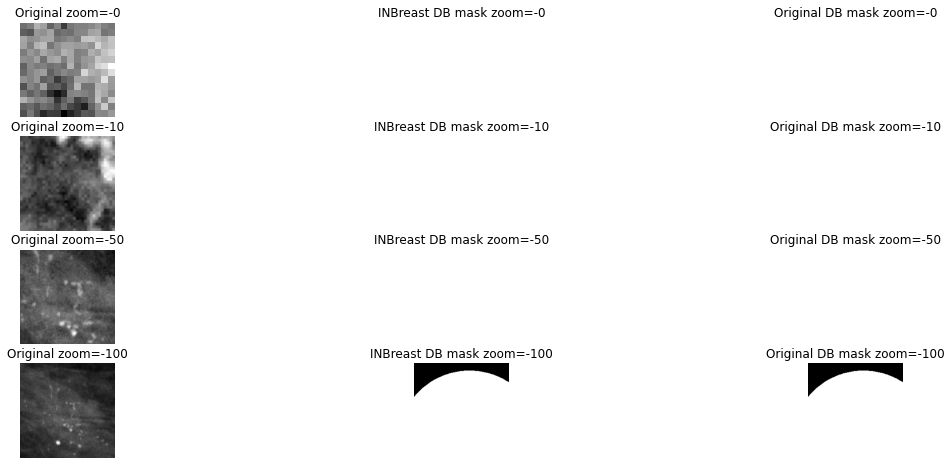

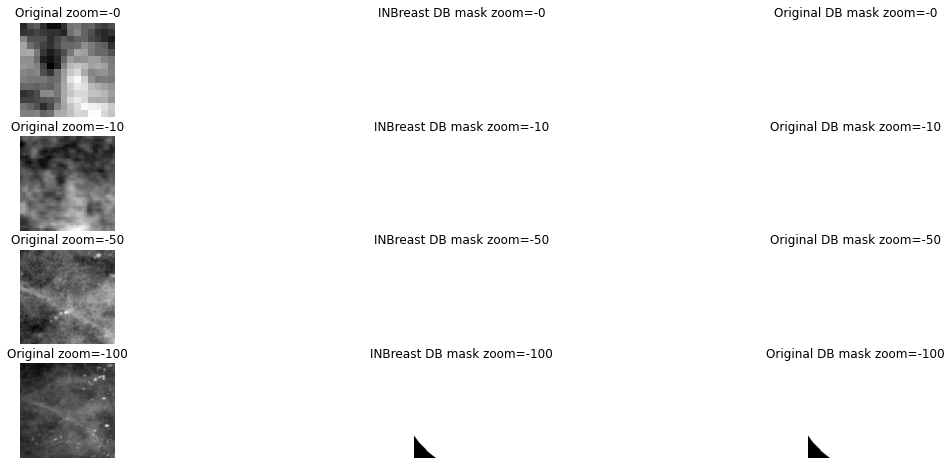

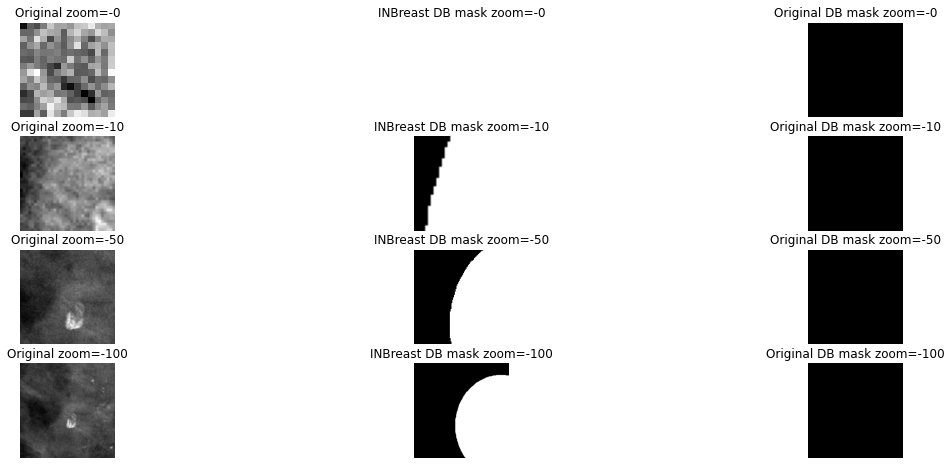

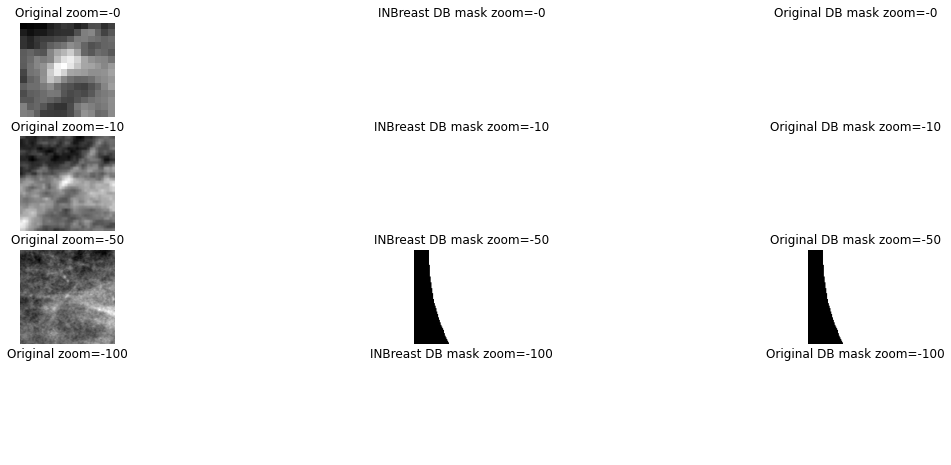

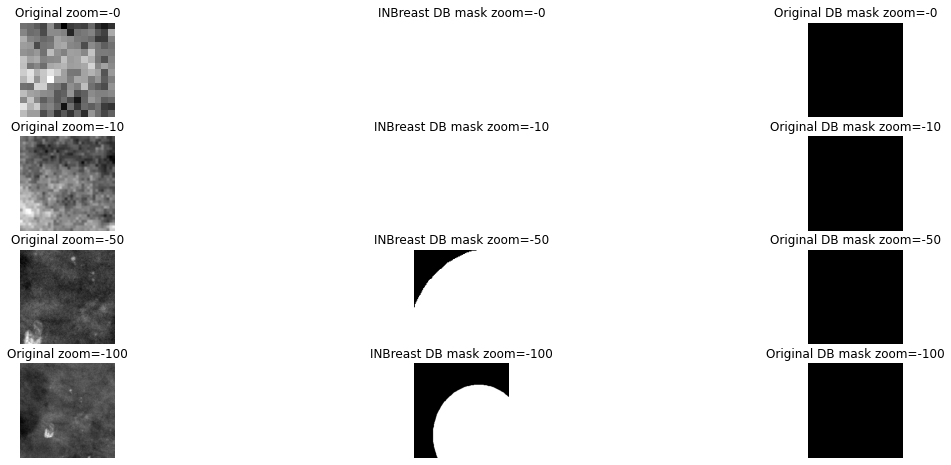

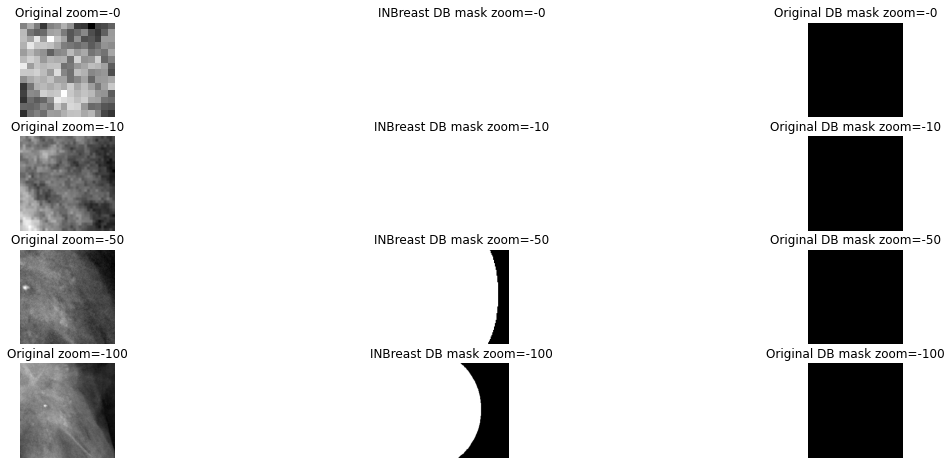

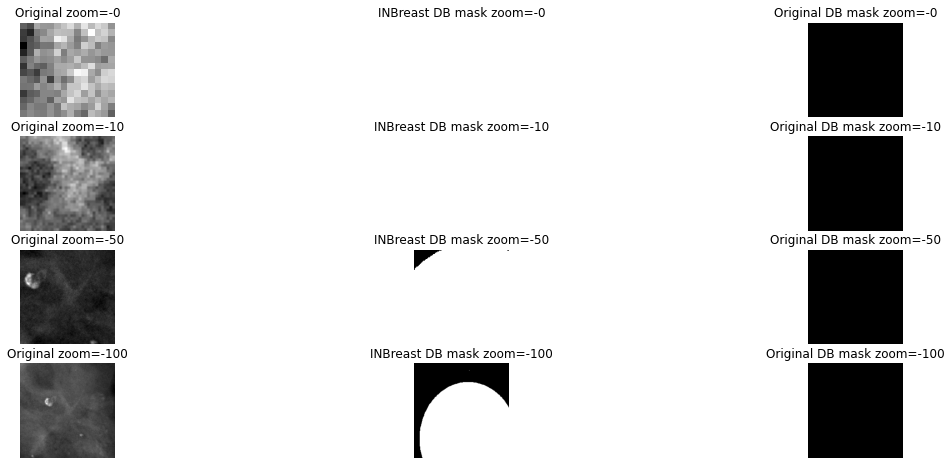

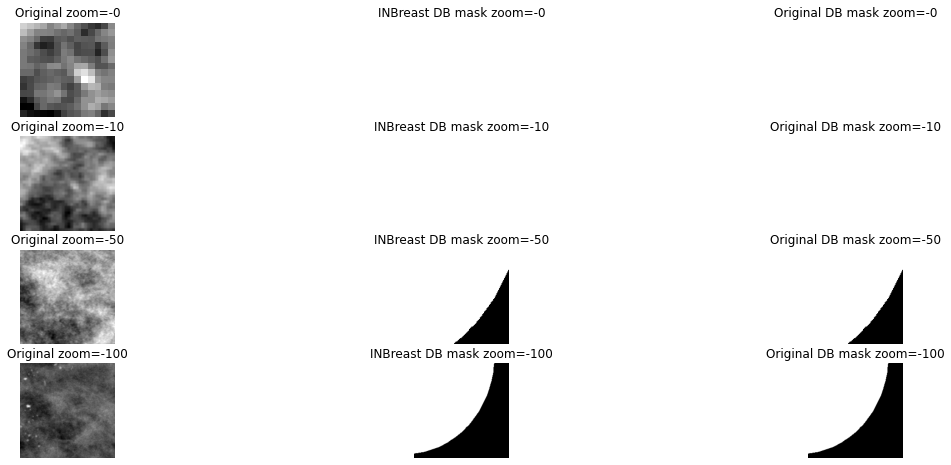

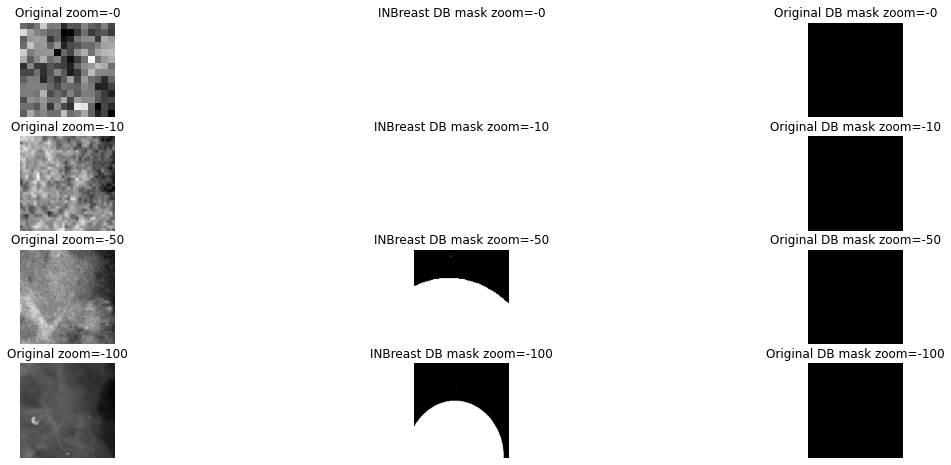

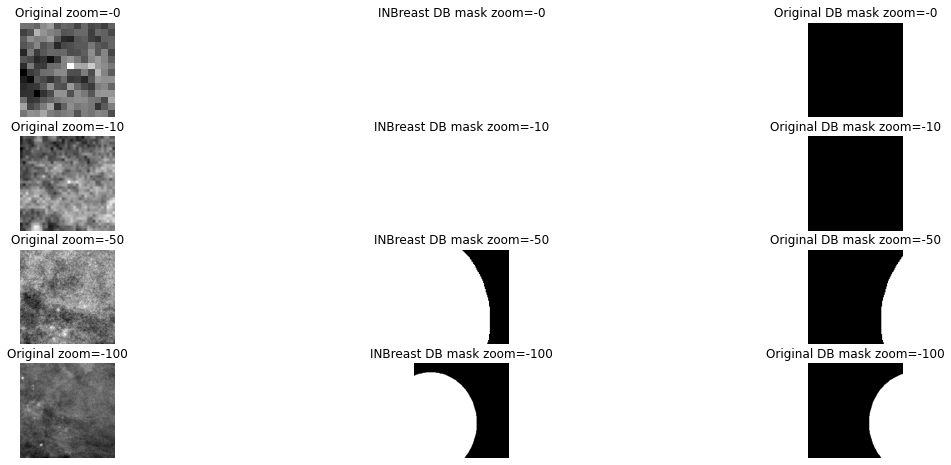

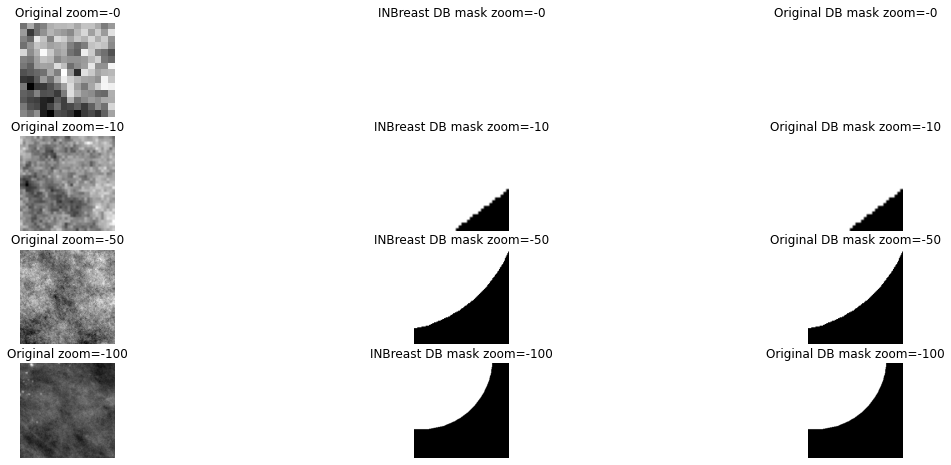

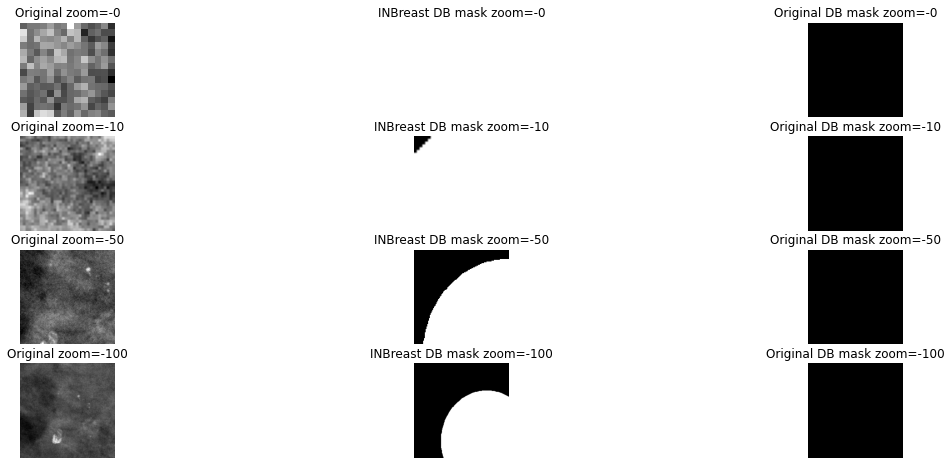

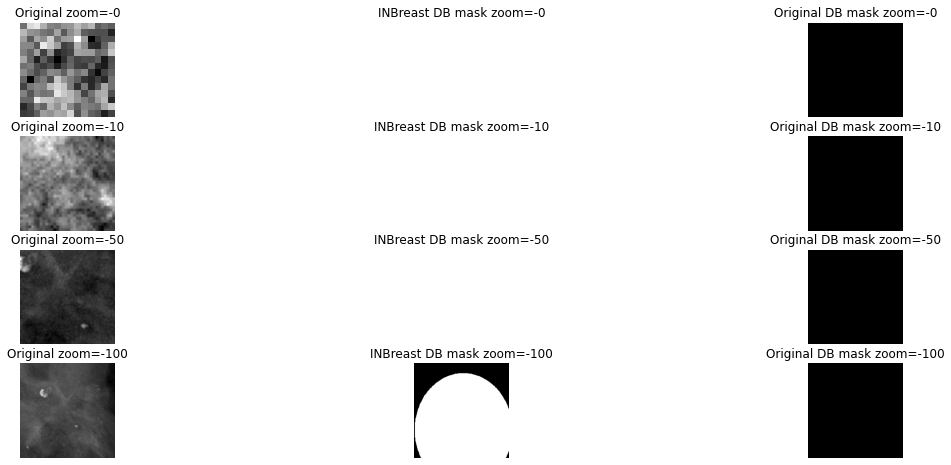

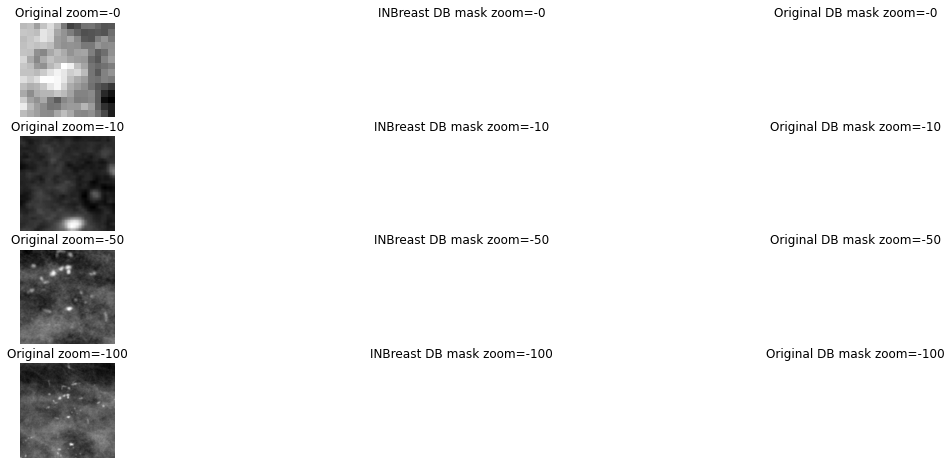

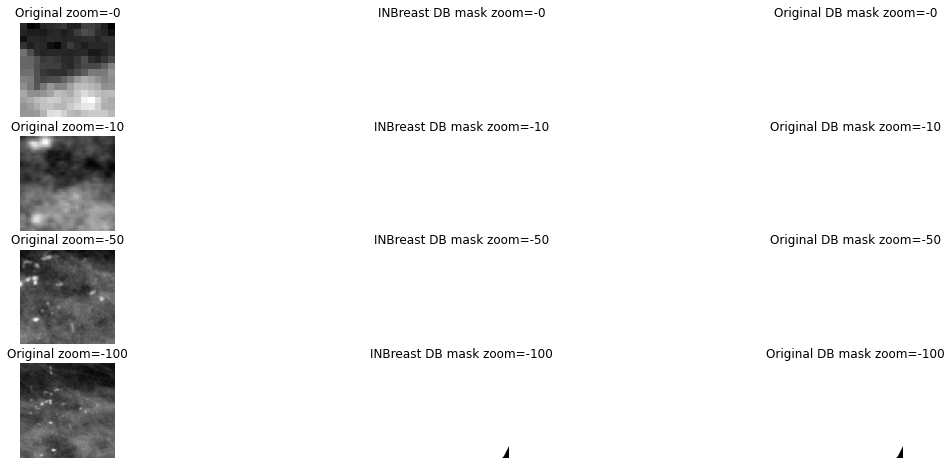

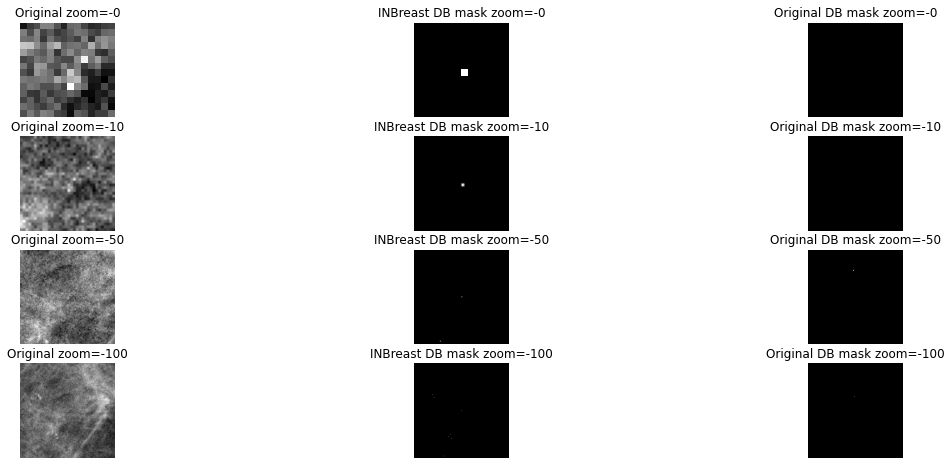

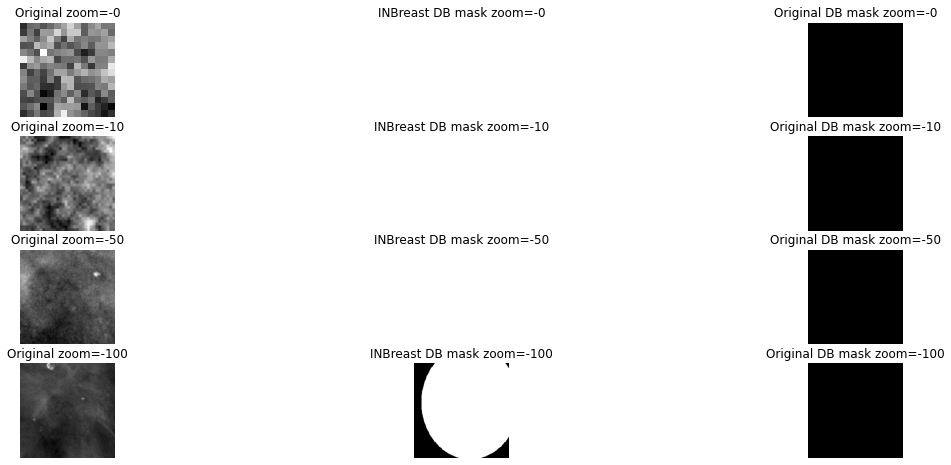

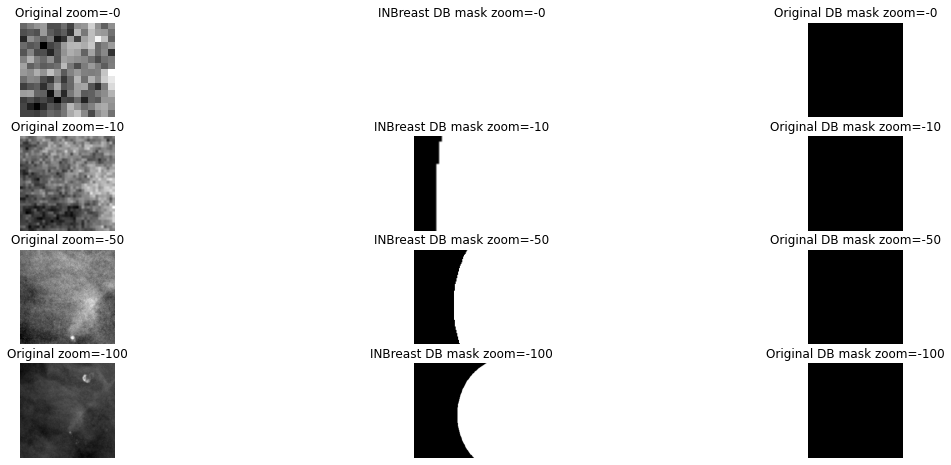

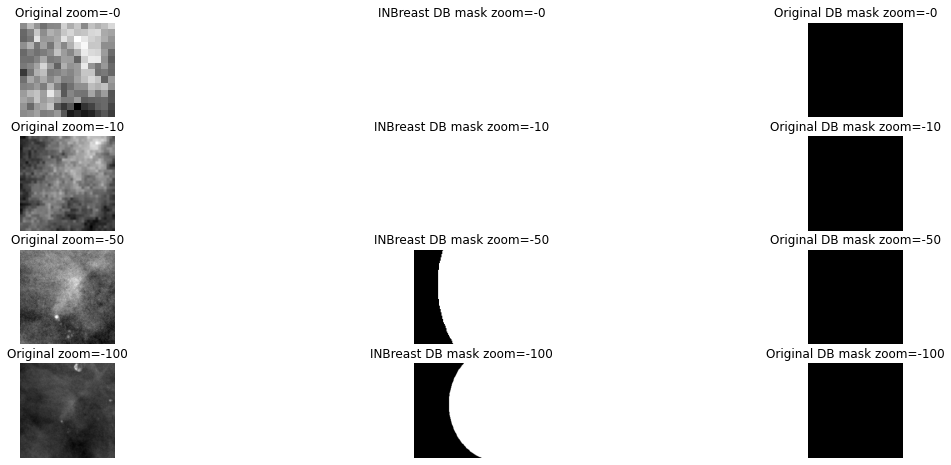

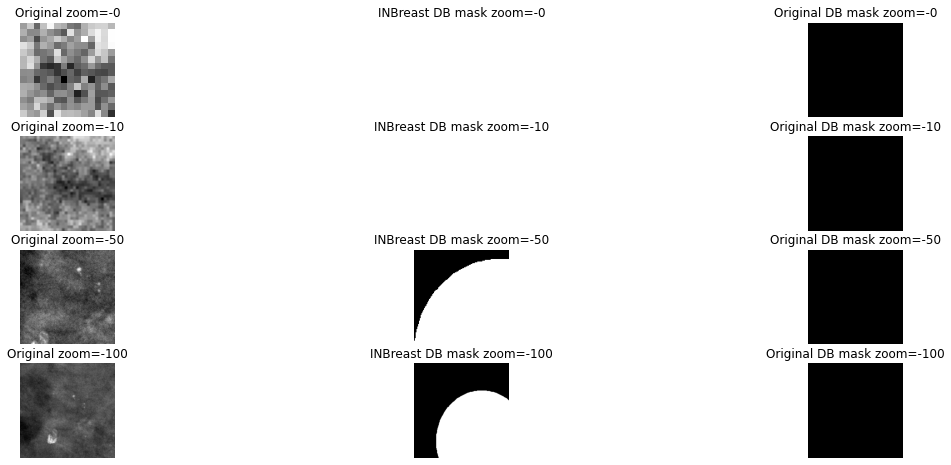

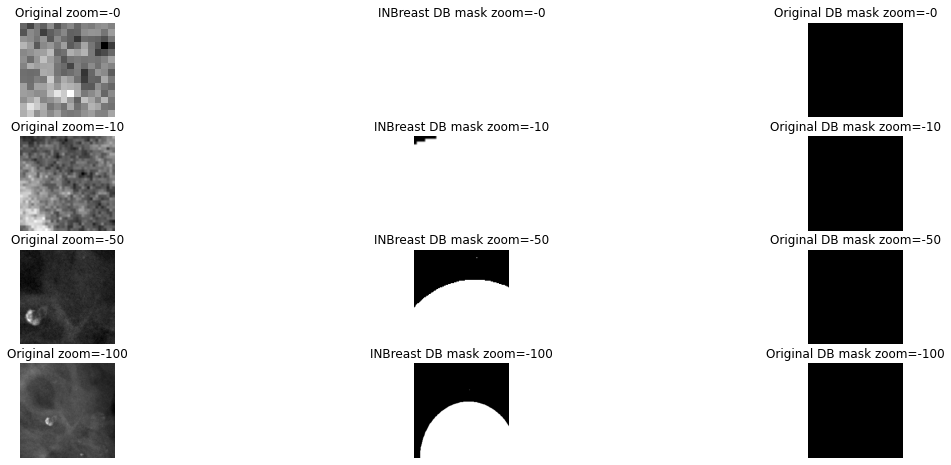

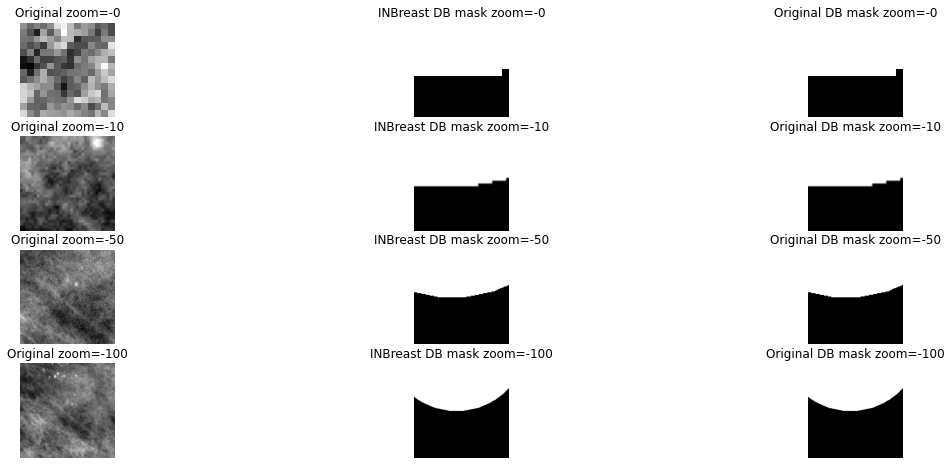

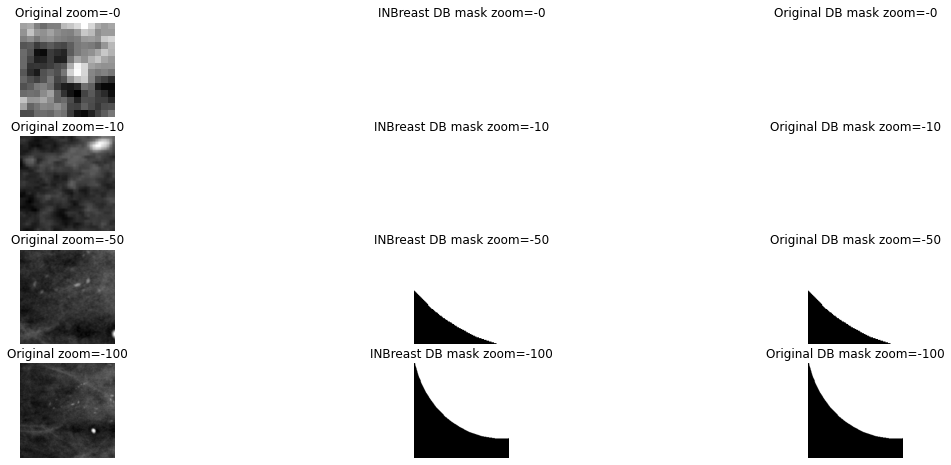

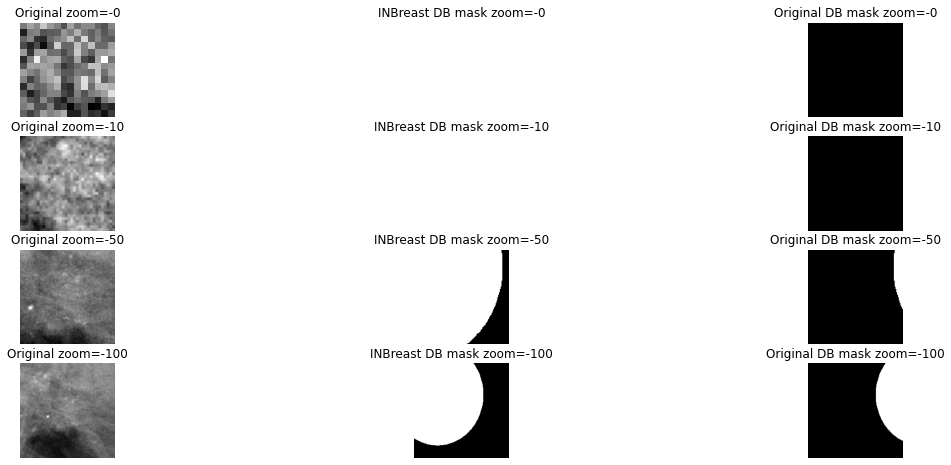

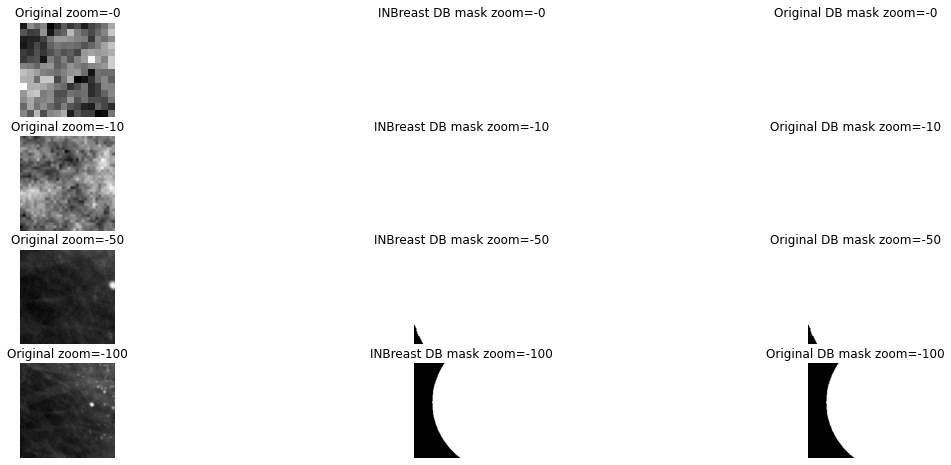

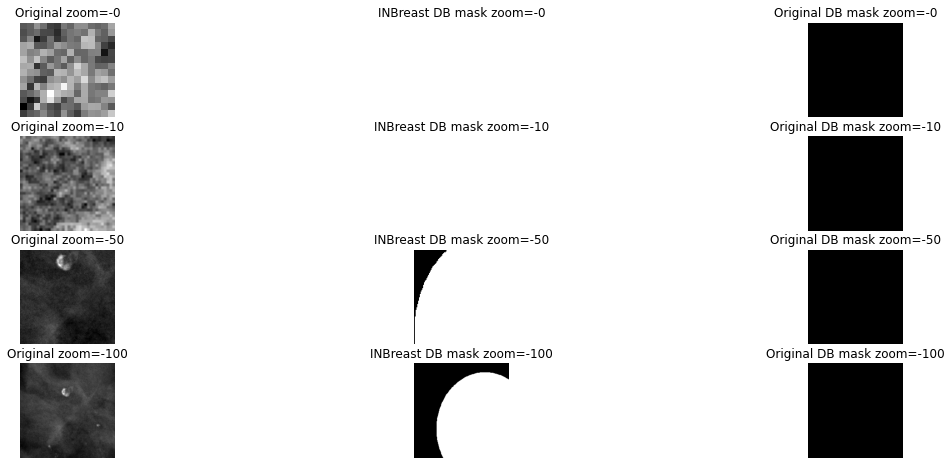

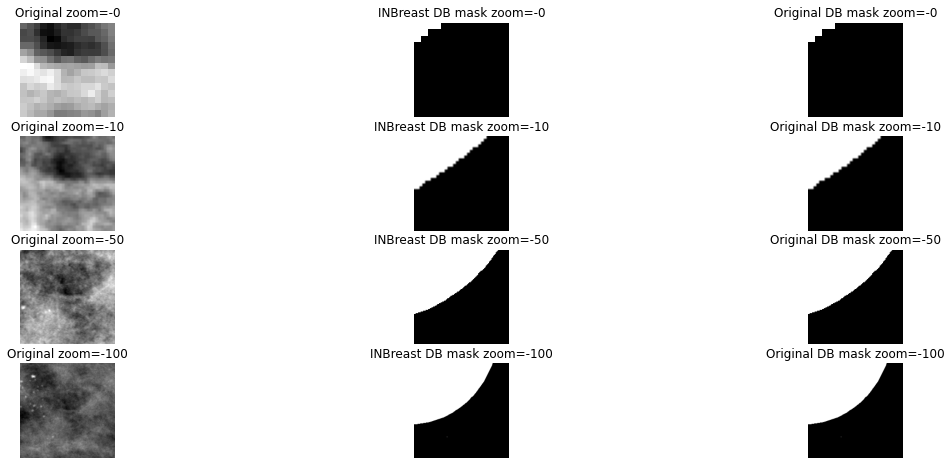

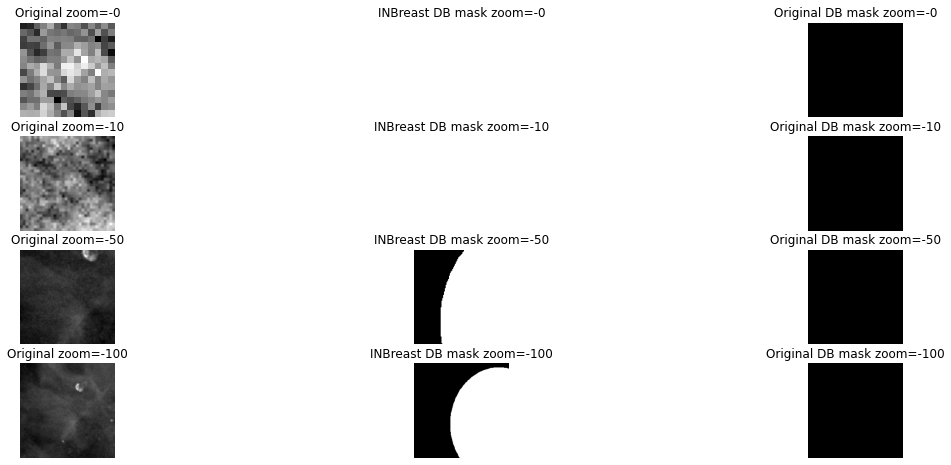

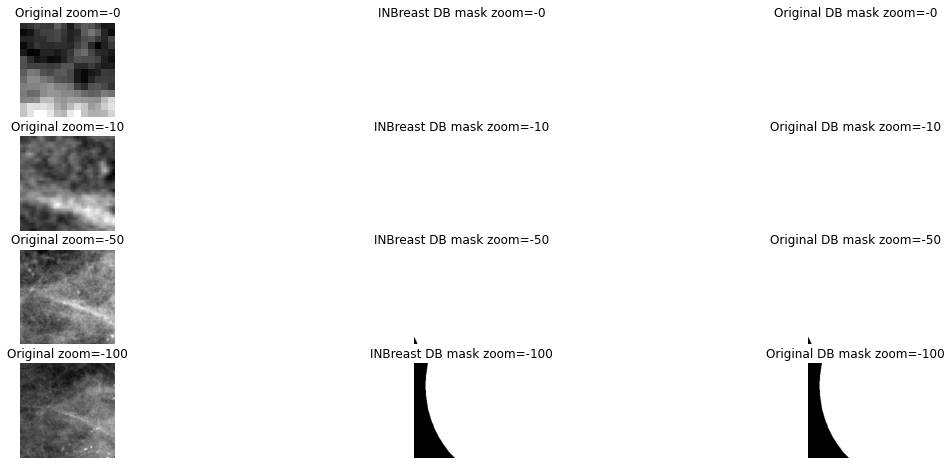

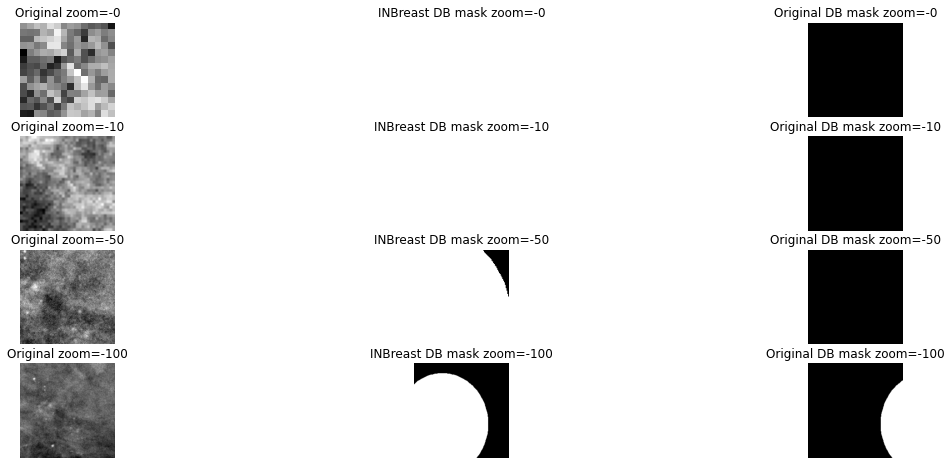

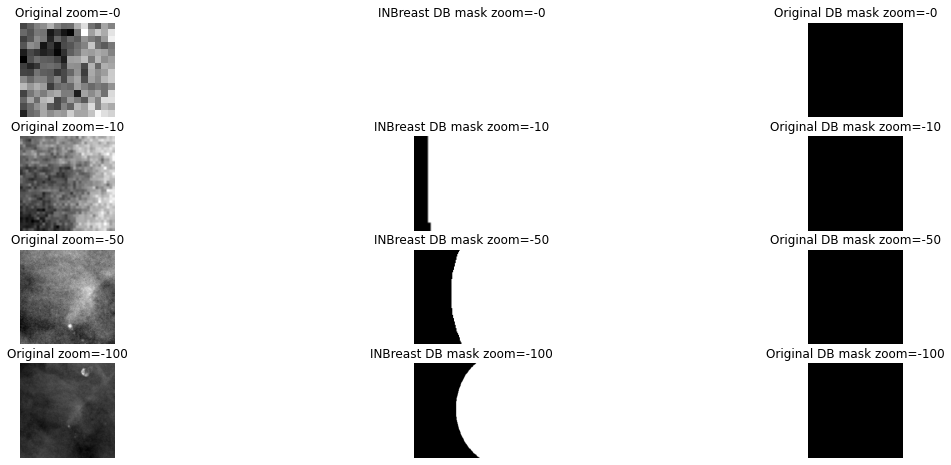

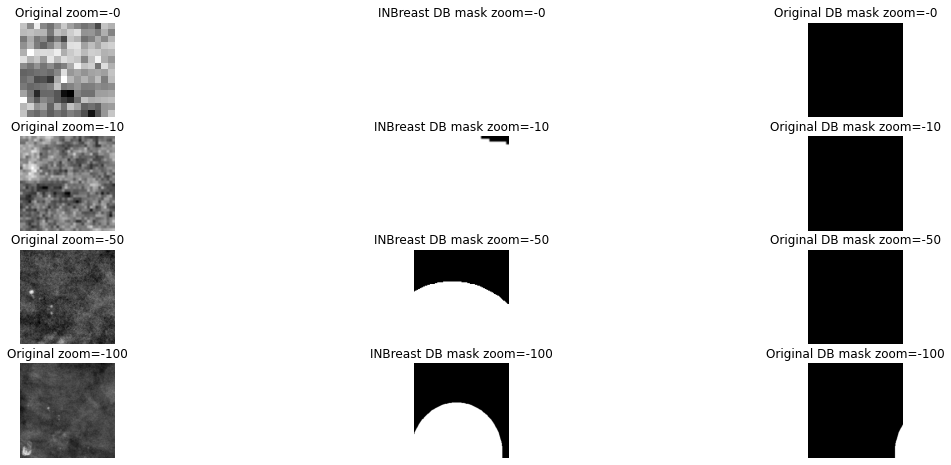

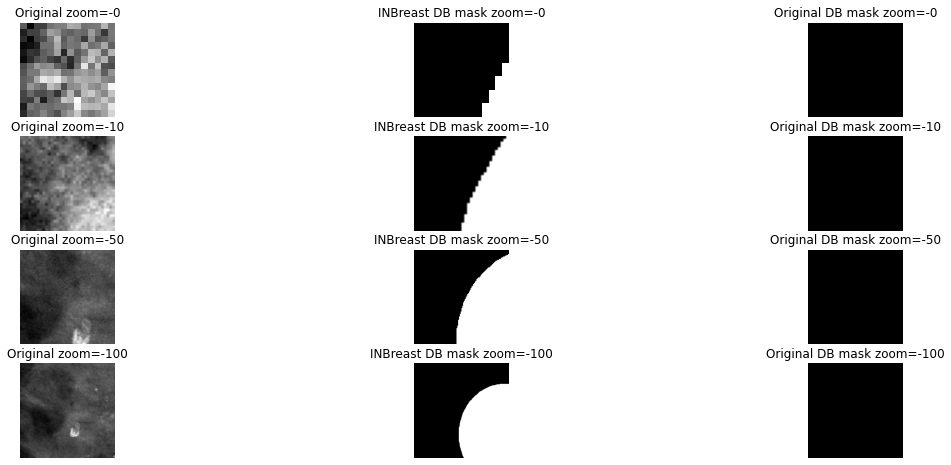

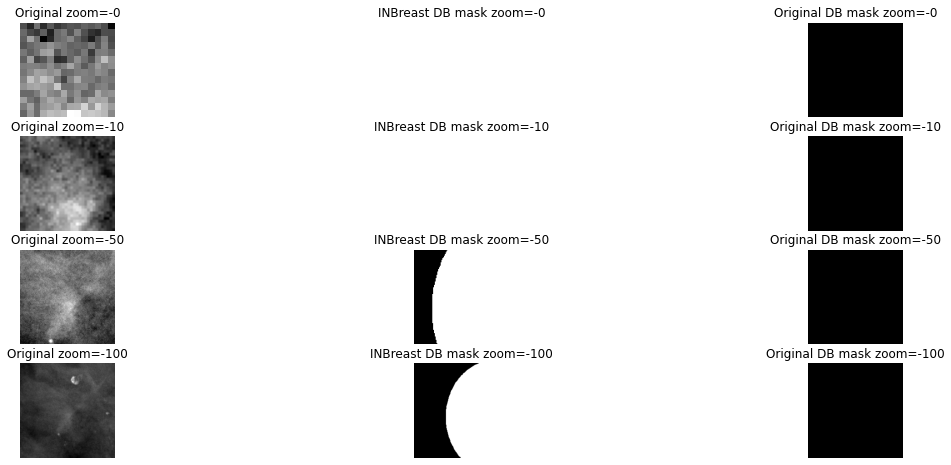

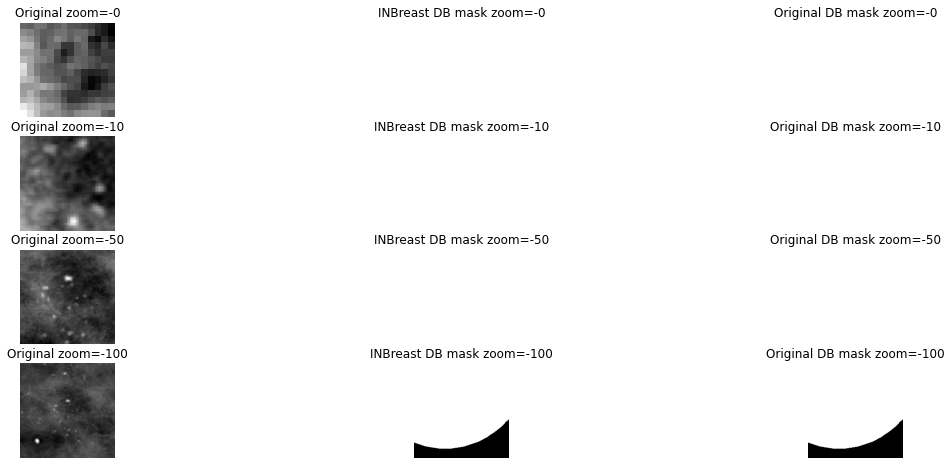

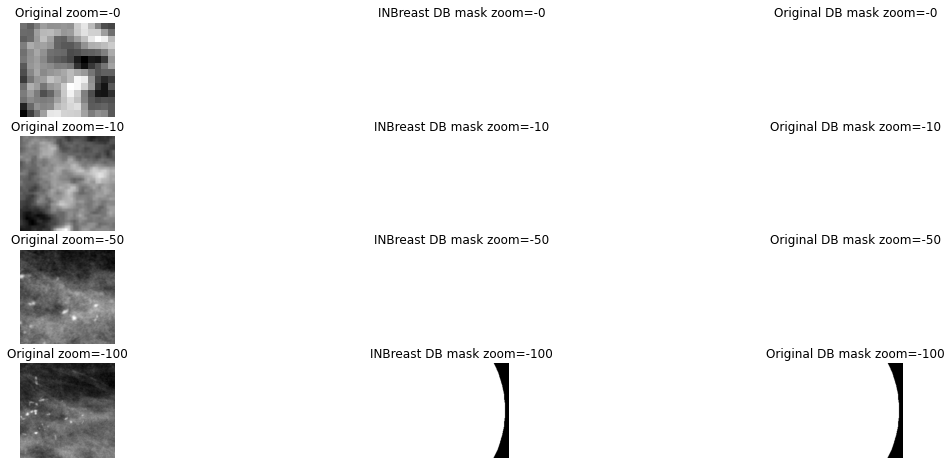

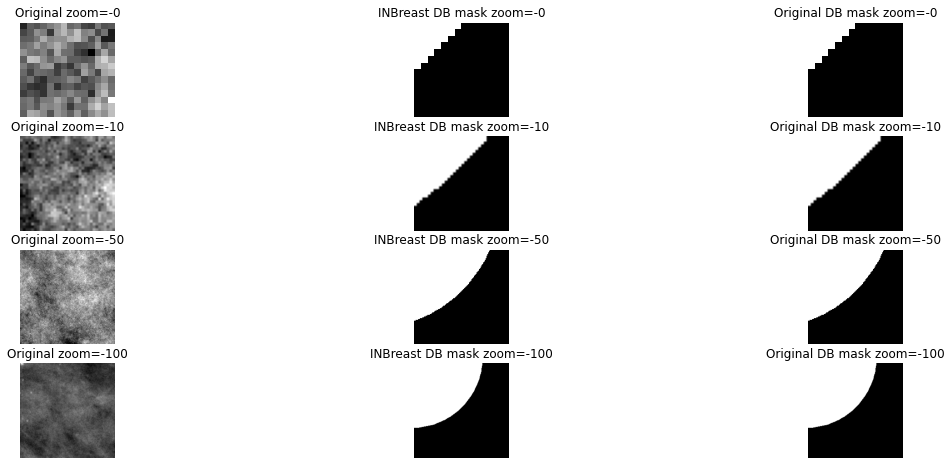

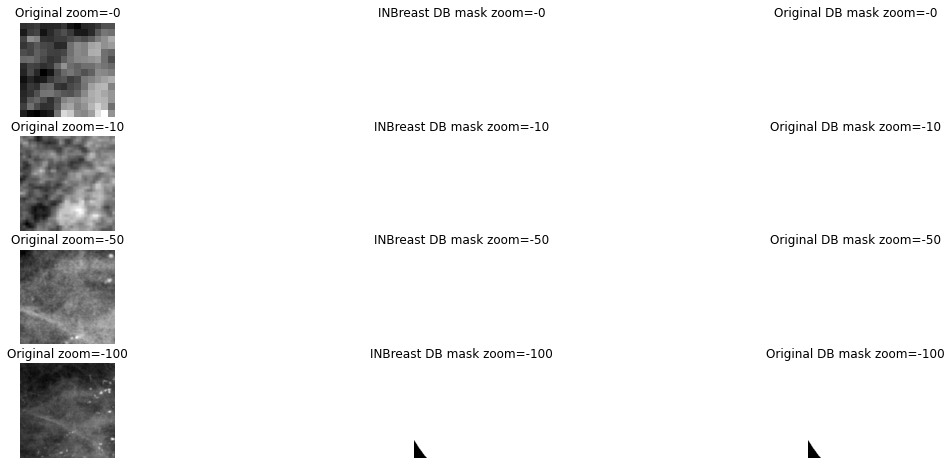

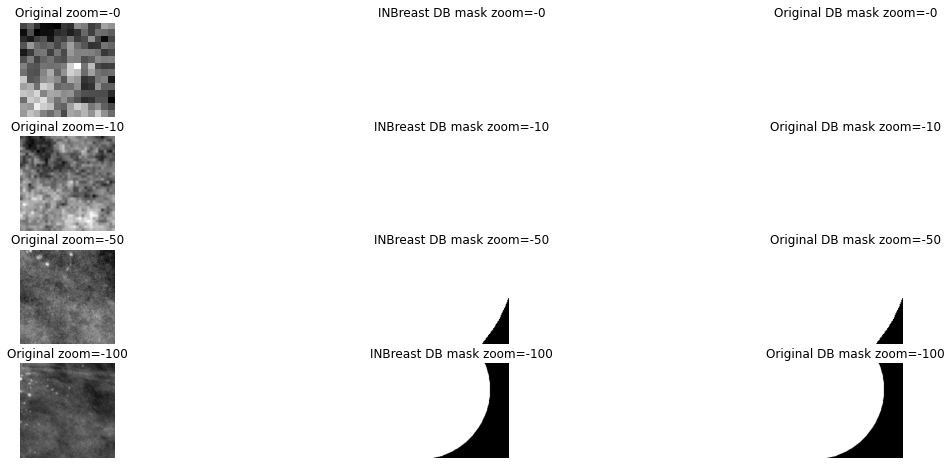

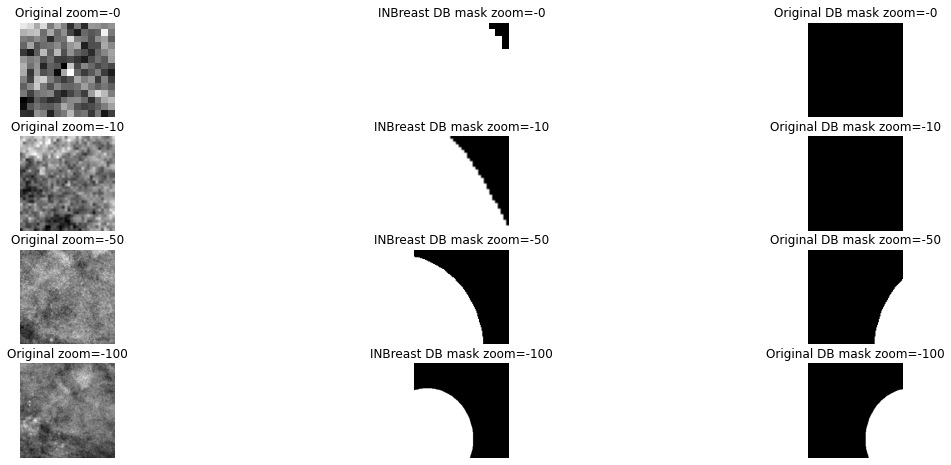

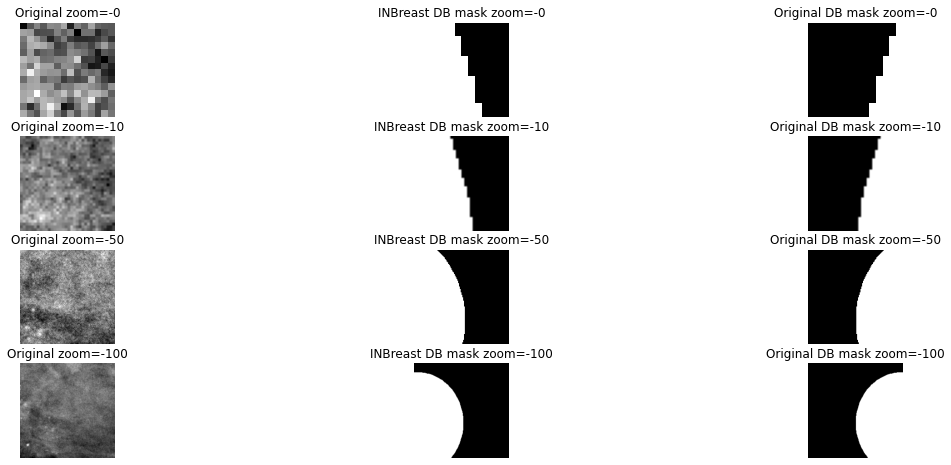

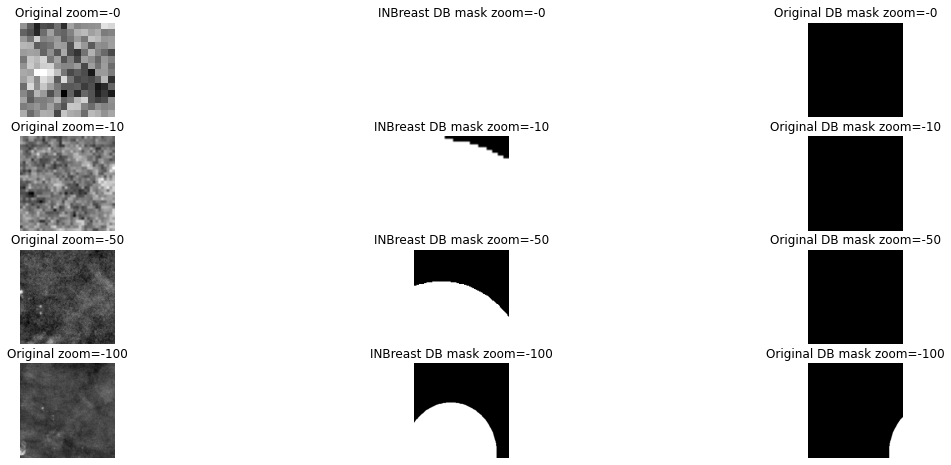

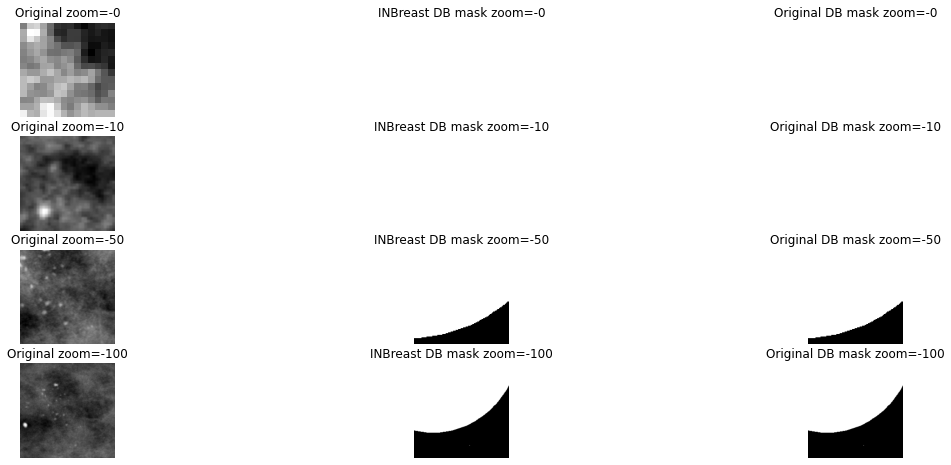

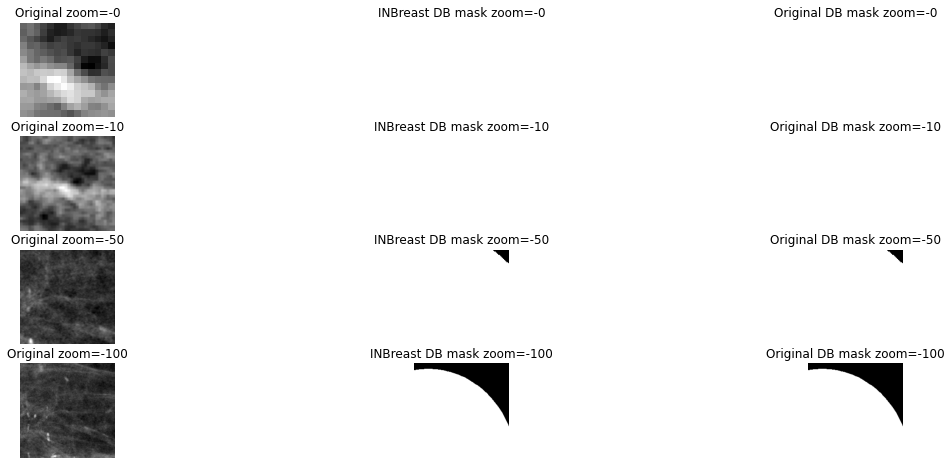

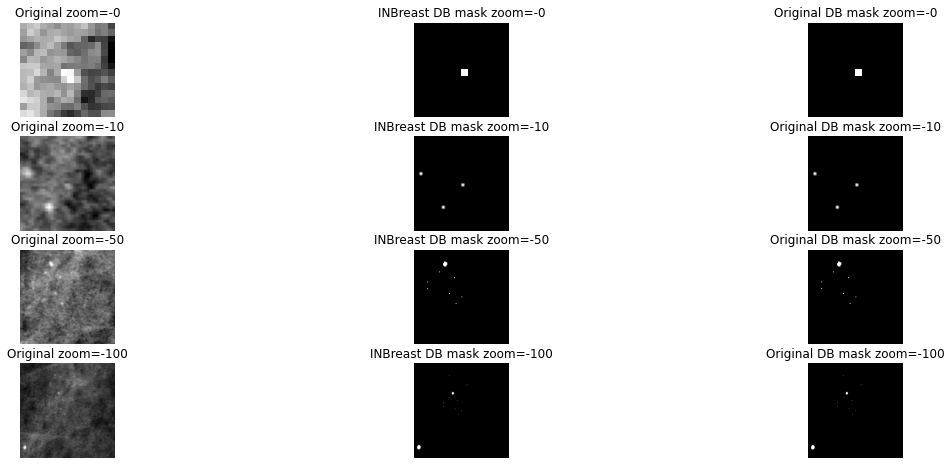

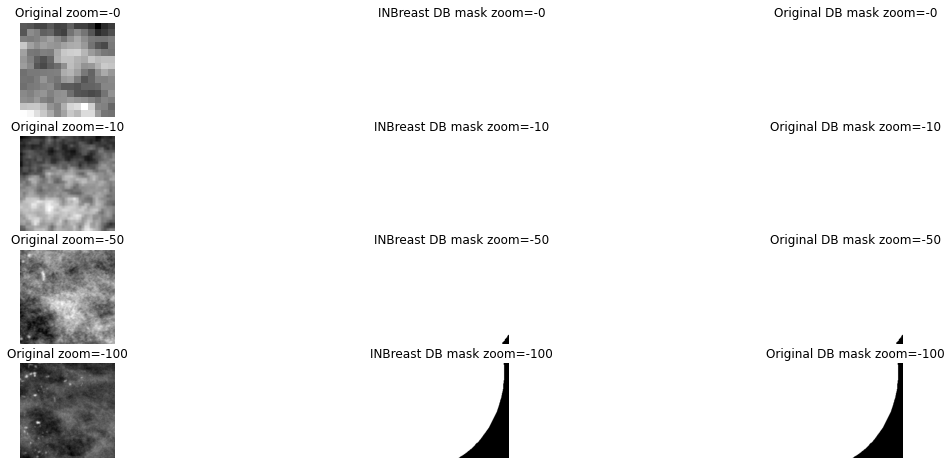

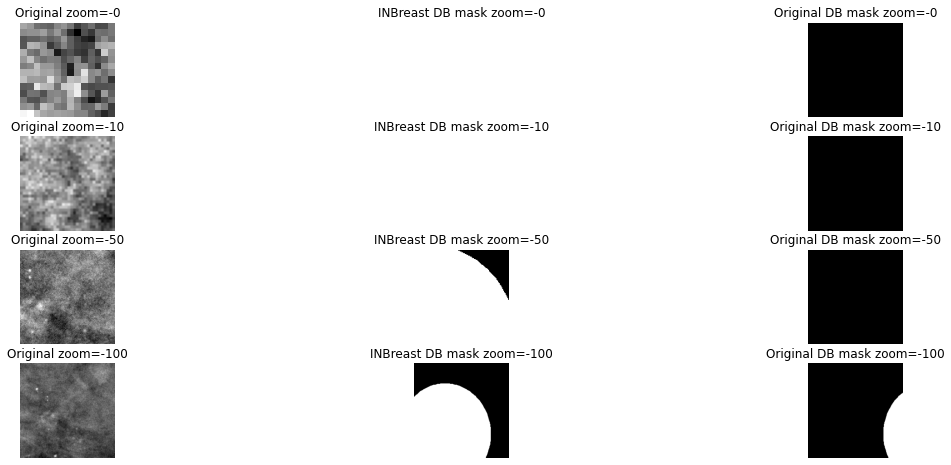

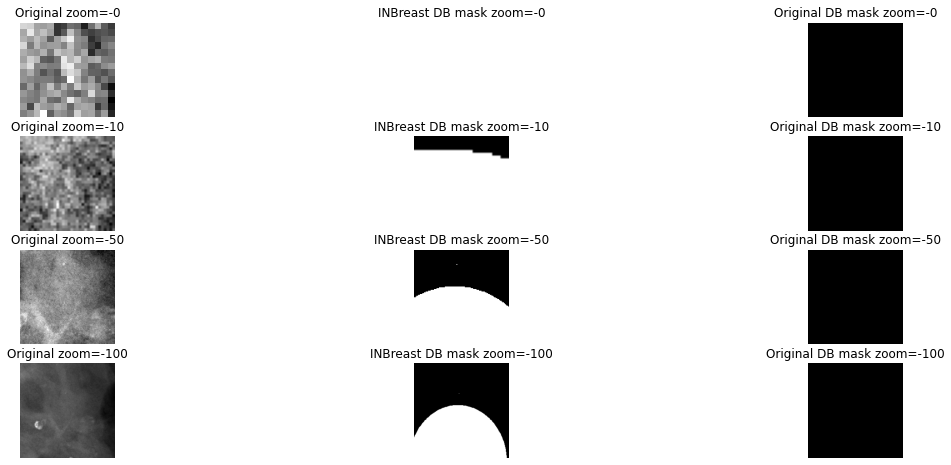

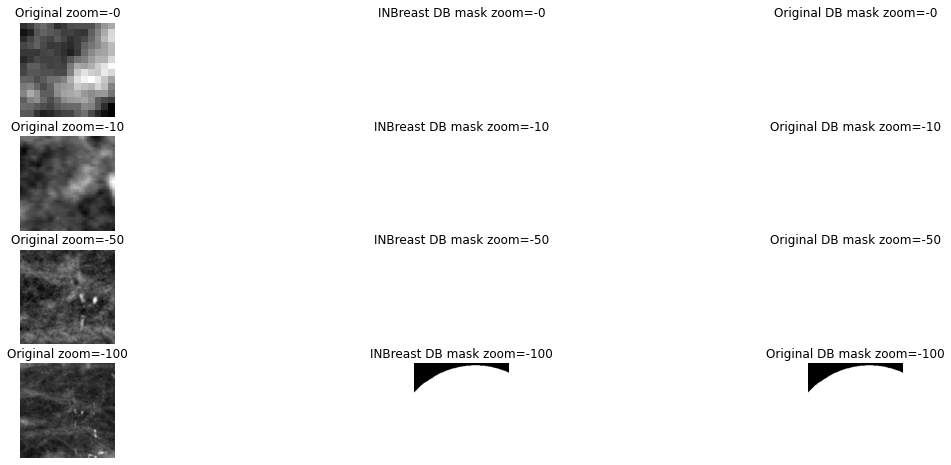

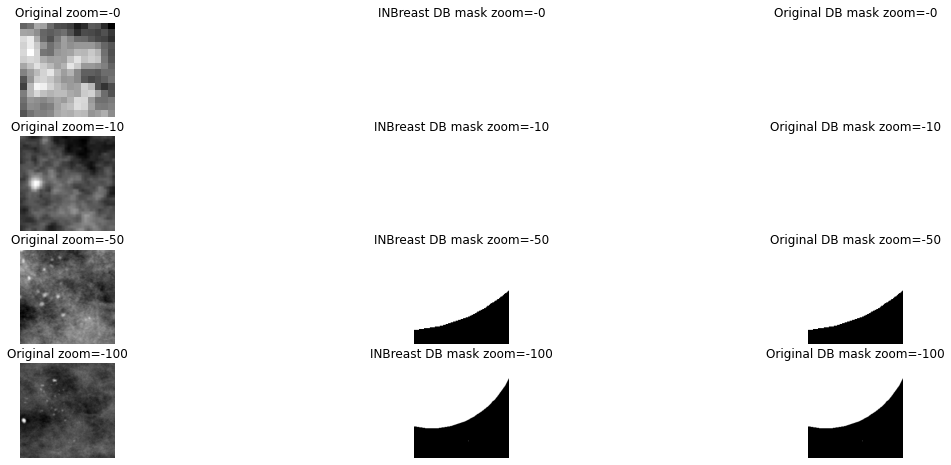

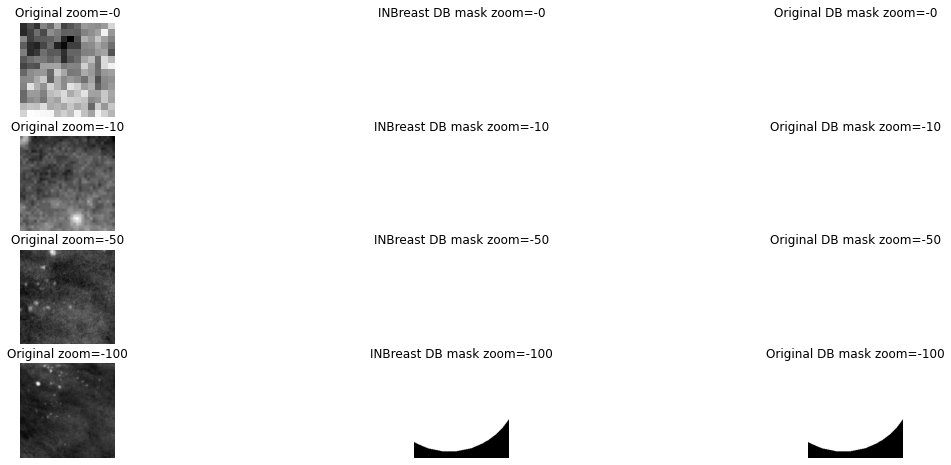

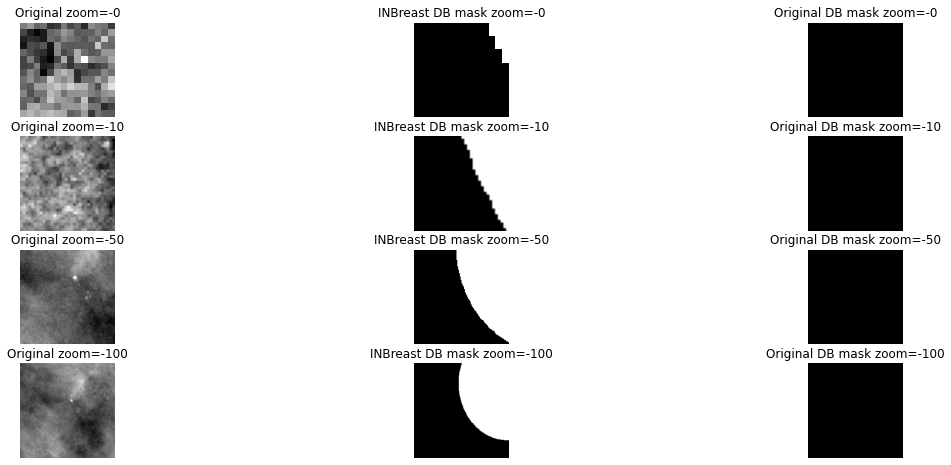

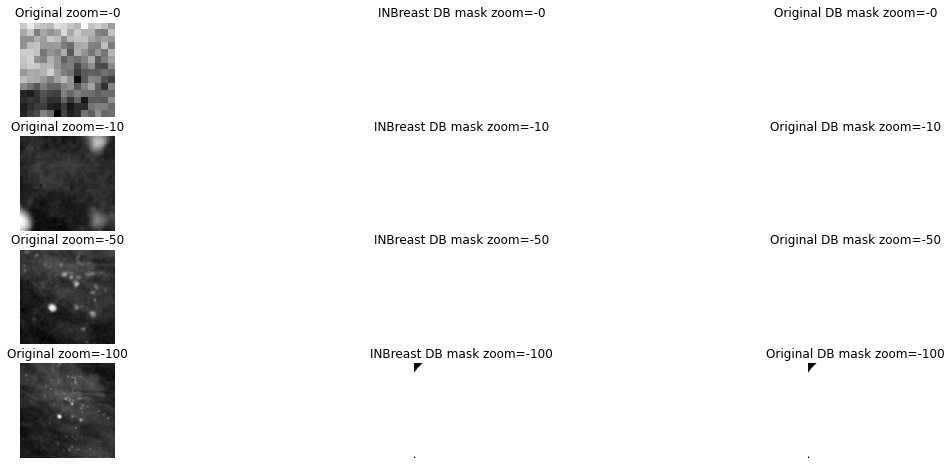

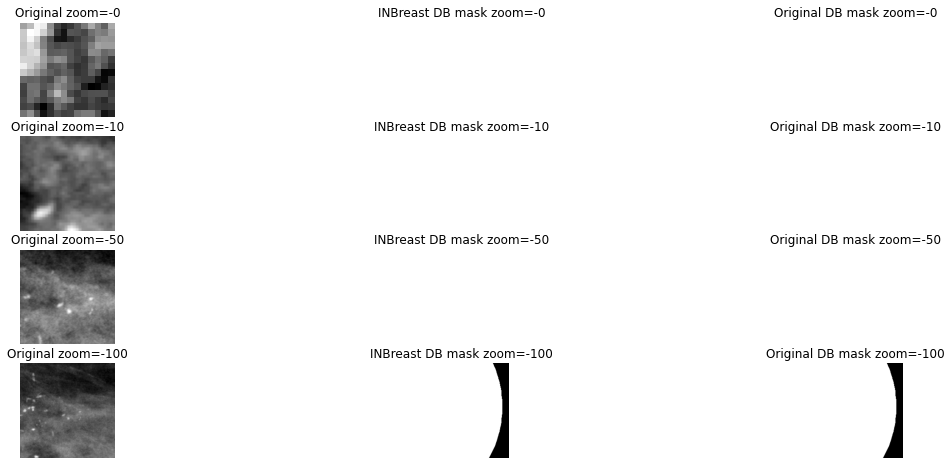

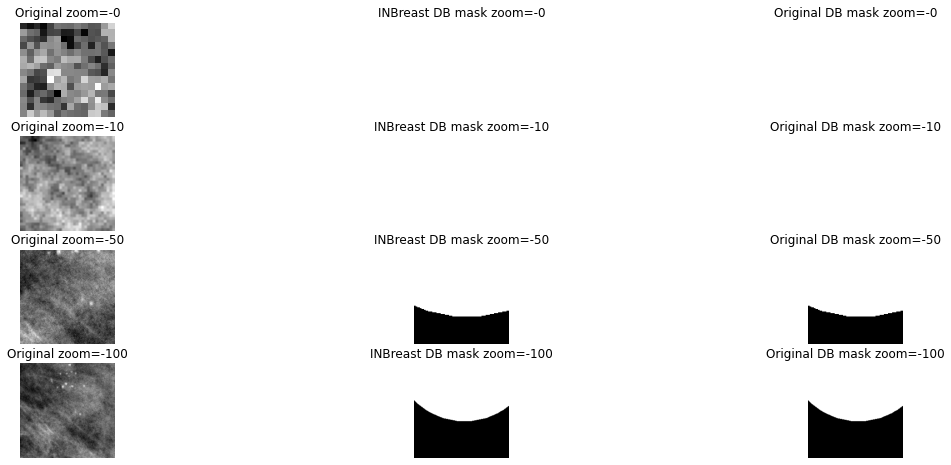

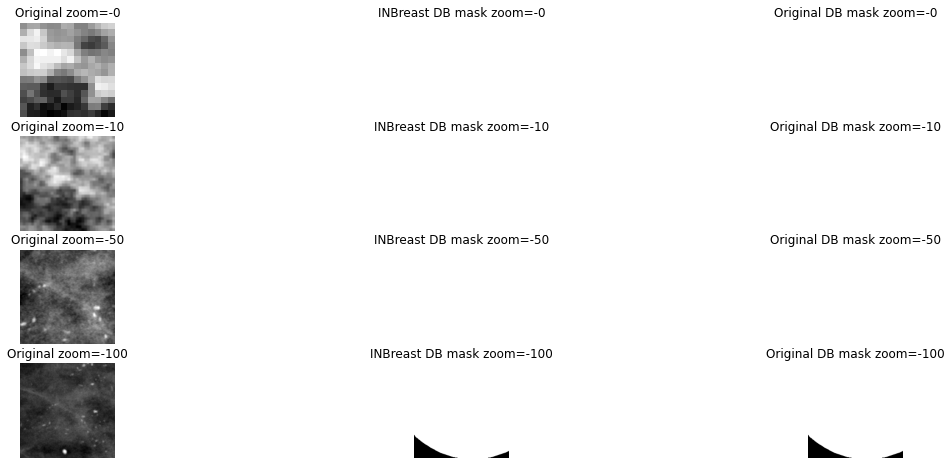

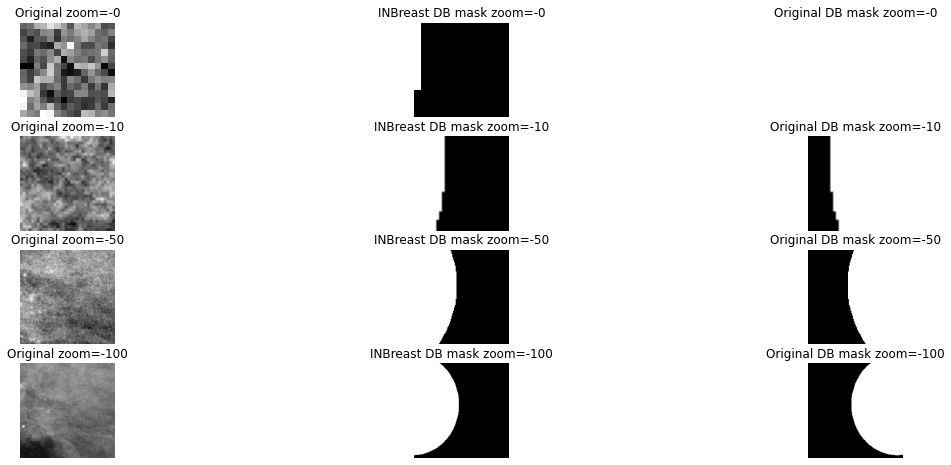

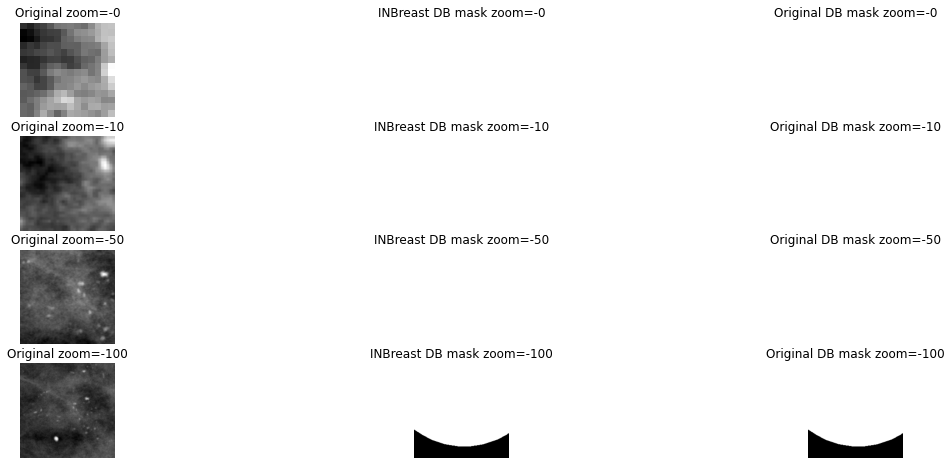

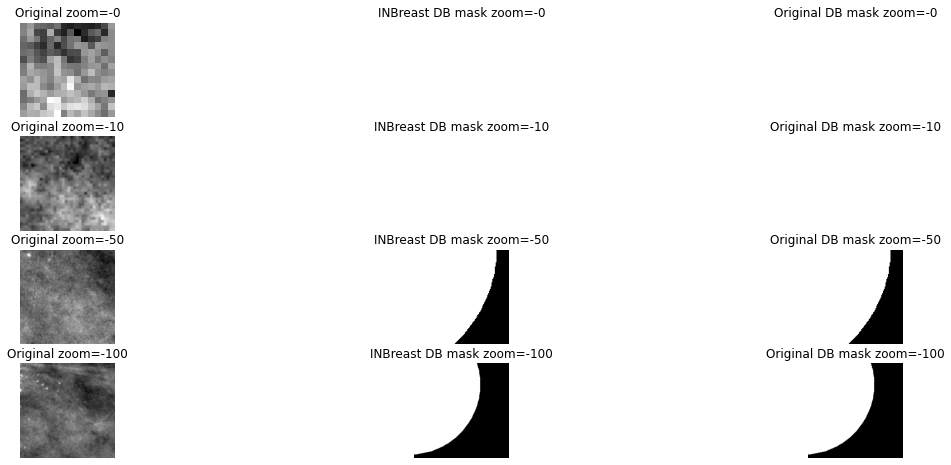

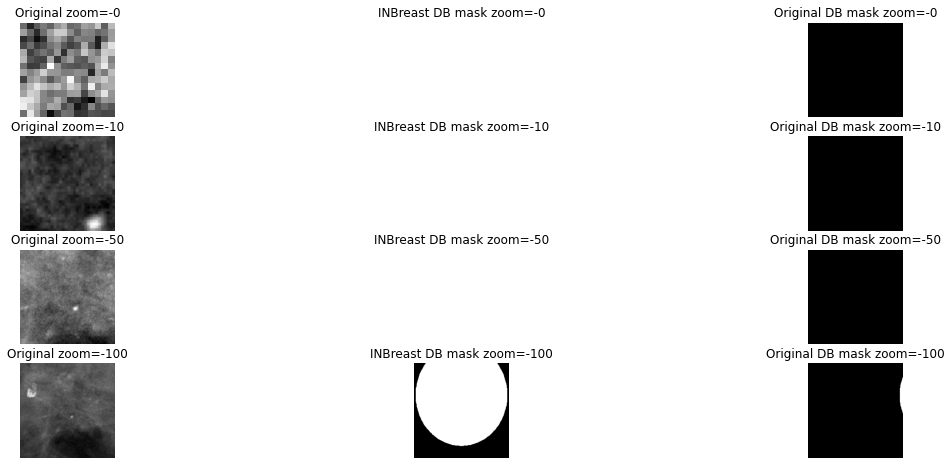

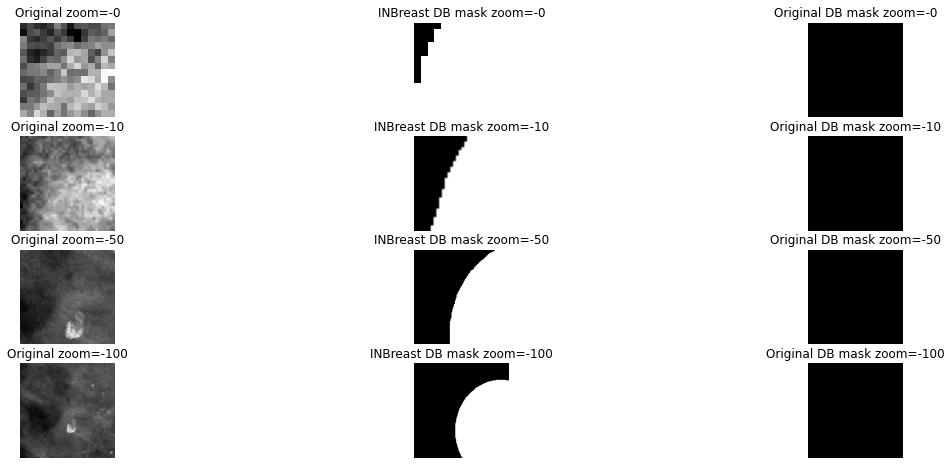

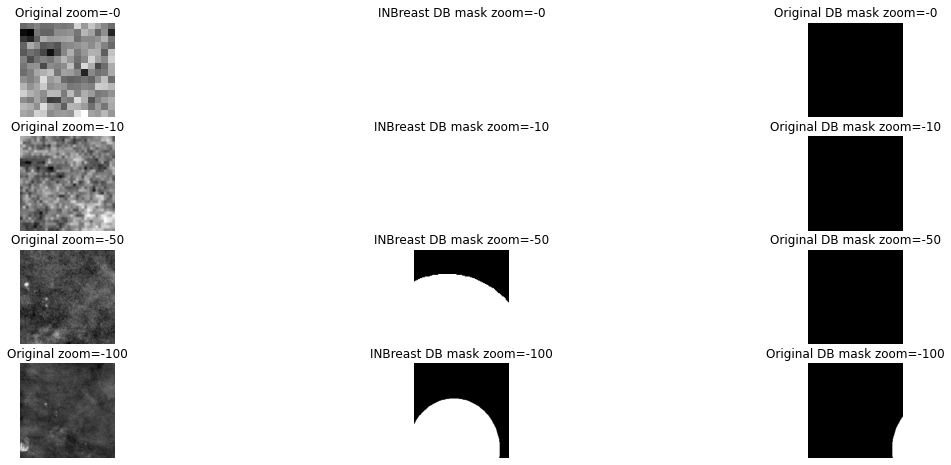

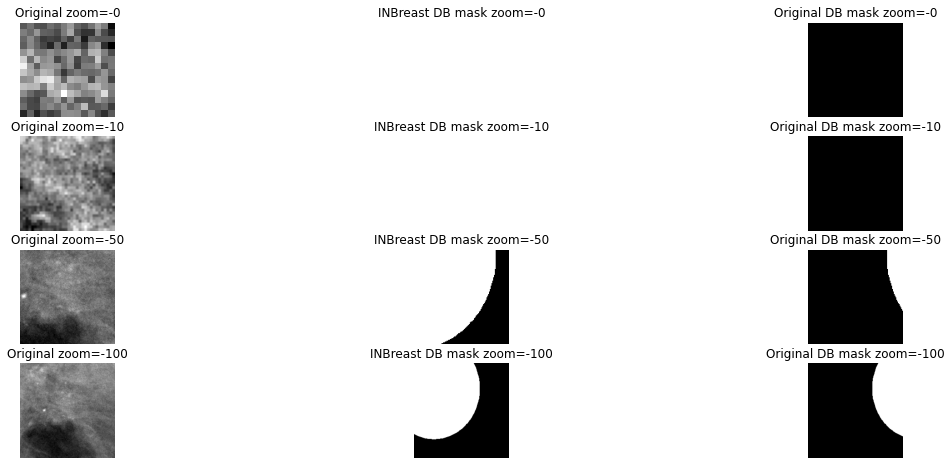

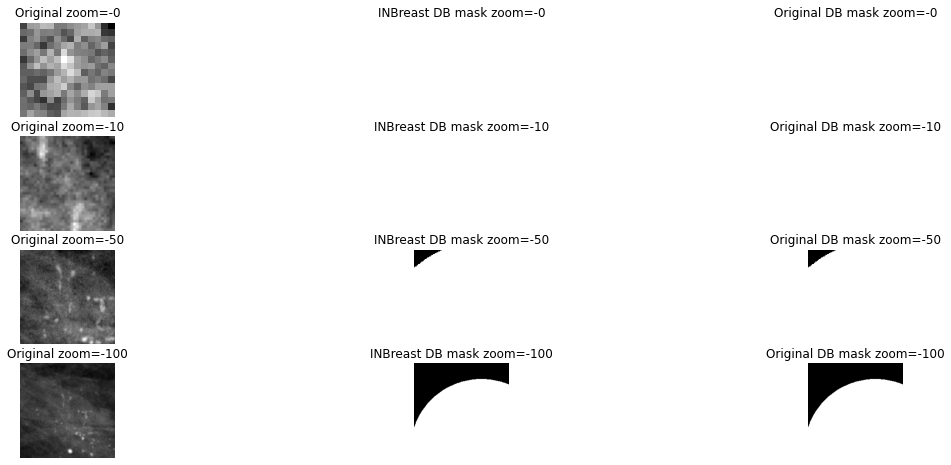

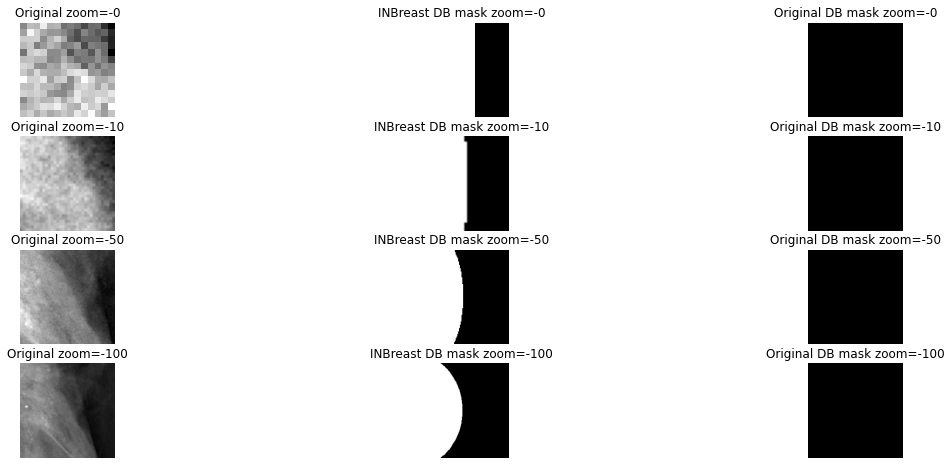

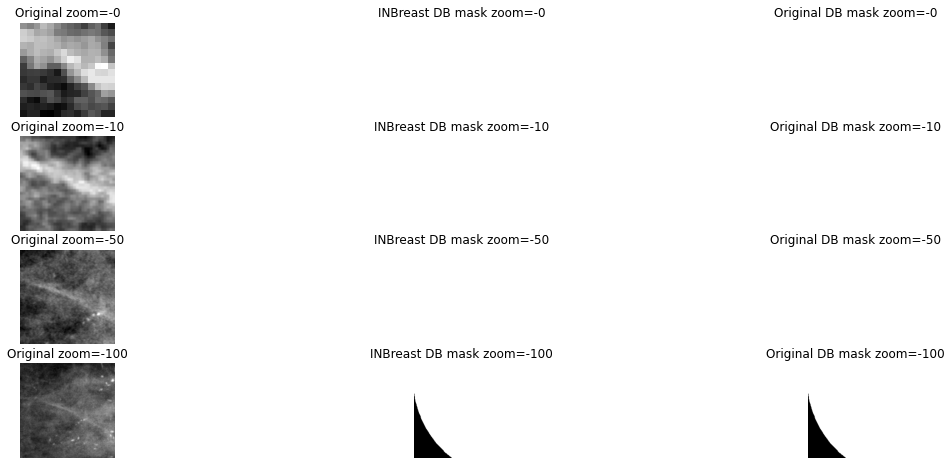

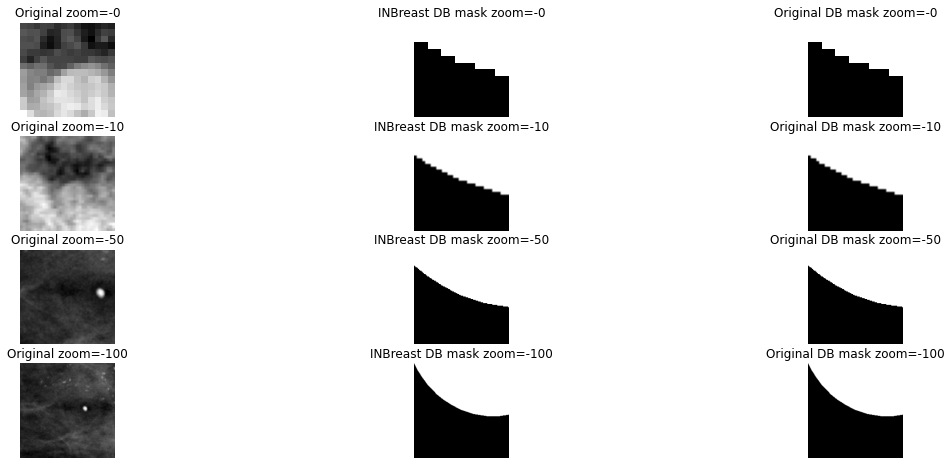

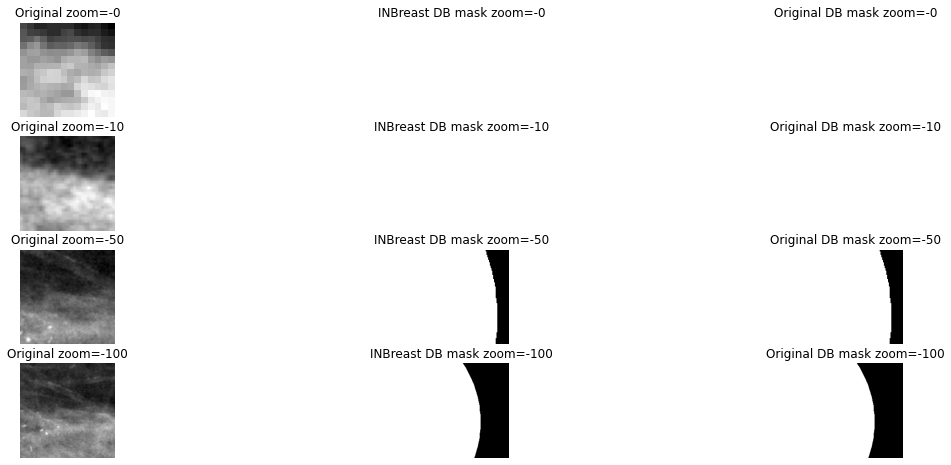

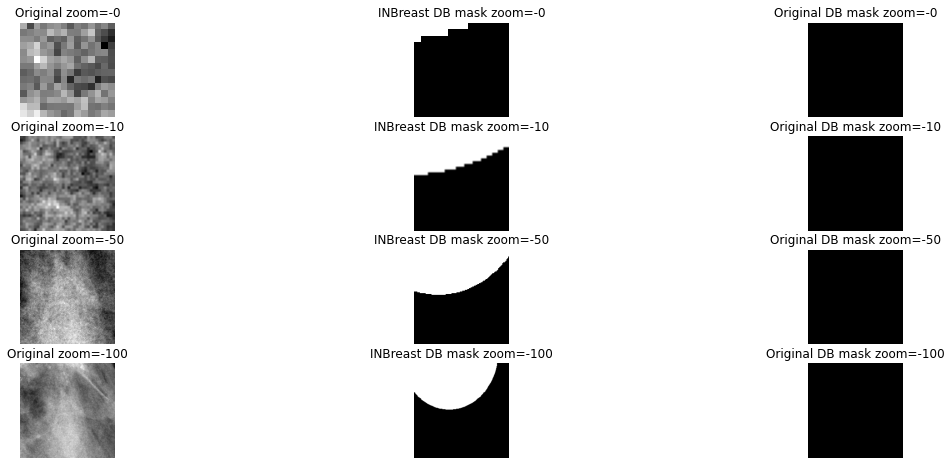

In [31]:

for _, bad_res in tqdm(bad_res_FN.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']


    fig, axs = plt.subplots(4,3, figsize=(20, 8))

    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(255*(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0), cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')

        if original_test_mask is not None:
            axs[didx, 2].imshow(255*(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0), cmap='gray', vmin=0)
            axs[didx, 2].axis('off')
            axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_results_FN/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    # plt.close(fig)

Two problems persist:
1. mC are labeled as big cluster
    * We need to consider clusters in INBreast db and let them pass size filter
2. mC are not labeled at all
    * Clustering and our labelling for clean pos/neg split used for final training

### Test on image

In [15]:
validation_img_ids

array([20587294, 20587320, 20587346, 20587372, 20587612, 20587638,
       20587664, 20587690, 22613918, 22613944, 22613970, 22613996,
       22614074, 22614097, 22614127, 22614150, 24055877, 24055904,
       24055931, 24055958, 24065680, 24065707, 24065734, 24065761,
       30011484, 30011507, 30011530, 30011553, 30011798, 30011824,
       30011850, 30318067, 50993616, 50993643, 50993670, 50993697,
       50994706, 50994733, 50994760, 50994787, 50994814, 50994841,
       50994868, 50994895, 50996056, 50996083, 50996110, 50996137,
       50996325, 50996352, 50996379, 50996406, 50996709, 50996736,
       50998580, 50998607, 50998634, 50998661, 51048891, 51048918,
       51048945, 51048972])

In [20]:
valimg = 20587320
CONF_THR = 0.5
valimg_db_id = db.df[db.df.img_id == valimg].index[0]
image = db[valimg_db_id]['img']
lesion_bboxes = db[valimg_db_id]['lesion_bboxes']


In [21]:
val_candidates = test_df[test_df.img_id == valimg].sort_values(by=['confidence'], ascending=False)
tp_cands = val_candidates[val_candidates.labels]
tp_cands = tp_cands[tp_cands.confidence > CONF_THR]

fp_cands = val_candidates[~val_candidates.labels]
fp_cands = fp_cands[fp_cands.confidence > CONF_THR]

res_img = plot_bboxes_over_image(image, [lesion_bboxes,
                                         tp_cands.patch_coordinates.values,
                                         fp_cands.patch_coordinates.values],
                                 [(255, 255, 255), (0, 255, 0), (0, 0, 255)],
                                 ['rect', 'rect', 'rect'])

cv2.imwrite('validation_detection_results.png', res_img)

True

In [22]:
tp_cands

Empty DataFrame
Columns: [img_energy, img_entropy, img_uniformity, img_min, img_10th_perc, img_90th_perc, img_max, img_mean, img_median, img_inter_quartile_range, img_range, img_mean_abs_deviation, img_robust_mean_abs_deviation, img_rms, img_std, img_skew, img_kurt, gabor_energy_0, gabor_max_0, gabor_min_0, gabor_mean_0, gabor_std_0, gabor_skew_0, gabor_kurt_0, gabor_energy_1, gabor_max_1, gabor_min_1, gabor_mean_1, gabor_std_1, gabor_skew_1, gabor_kurt_1, gabor_energy_2, gabor_max_2, gabor_min_2, gabor_mean_2, gabor_std_2, gabor_skew_2, gabor_kurt_2, gabor_energy_3, gabor_max_3, gabor_min_3, gabor_mean_3, gabor_std_3, gabor_skew_3, gabor_kurt_3, gabor_energy_4, gabor_max_4, gabor_min_4, gabor_mean_4, gabor_std_4, gabor_skew_4, gabor_kurt_4, gabor_energy_5, gabor_max_5, gabor_min_5, gabor_mean_5, gabor_std_5, gabor_skew_5, gabor_kurt_5, patch_mean_LL1, patch_skew_LL1, patch_std_LL1, patch_kur_LL1, patch_entropy_LL1, patch_uniformity_LL1, patch_relsmooth_LL1, patch_mean_LH1, patch_skew_LH1, patch_std_LH1, patch_kur_LH1, patch_entropy_LH1, patch_uniformity_LH1, patch_relsmooth_LH1, patch_mean_HL1, patch_skew_HL1, patch_std_HL1, patch_kur_HL1, patch_entropy_HL1, patch_uniformity_HL1, patch_relsmooth_HL1, patch_mean_HH1, patch_skew_HH1, patch_std_HH1, patch_kur_HH1, patch_entropy_HH1, patch_uniformity_HH1, patch_relsmooth_HH1, patch_mean_LL2, patch_skew_LL2, patch_std_LL2, patch_kur_LL2, patch_entropy_LL2, patch_uniformity_LL2, patch_relsmooth_LL2, patch_mean_LH2, patch_skew_LH2, patch_std_LH2, patch_kur_LH2, patch_entropy_LH2, patch_uniformity_LH2, ...]
Index: []

[0 rows x 159 columns]

In [23]:
fp_cands.patch_coordinates.values

array([], dtype=object)